# Utilities

In [1]:
data_dir = '../data/'
model_dir = '../models/'
results_dir = '../results/'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from tqdm import tqdm

def make_corr_plot(actual, predicted):

    m = 1
    b = 0
    correlation_coefficient, p_value = pearsonr(actual[:10000], predicted[:10000])
    x = np.arange(actual.min(), actual.max(), step=0.1)

    fig = plt.figure(figsize=(8, 6))
    plt.scatter(actual, predicted, s=30, alpha=0.2)
    plt.plot(x, m*x + b, color='red')
    plt.xlabel('Truth Number of Primary Ionizations')
    plt.ylabel('Predicted Number of Primary Ionizations')
    plt.text(0.05,0.95, f"Correlation coefficient = {correlation_coefficient:.2f}", fontsize=12, color='black', 
             transform=plt.gca().transAxes,
             horizontalalignment='left',    
             verticalalignment='top', )
    plt.grid(True, color='gray', linestyle='--', alpha=0.4)
    plt.title('Truth vs. Predicted Number of Primary Ionizations')

def plot_percent_error(actual, predicted):
    mask = actual != 0
    actual = actual[mask]
    predicted = predicted[mask]
    error = ((predicted - actual)/actual) * 100

    plt.hist(error,bins=np.arange(-100, 100, 2),histtype='bar',label='Error', edgecolor="black", fc="#69b3a2", alpha=0.3)
    plt.title('Histogram of Percent Error')
    plt.xlabel('Error (%)')

    mean = np.mean(error)
    std = np.std(error.astype(np.float32))

    plt.axvline(mean, color='red', linestyle='--', linewidth=2)
    
    plt.text(0.05, 0.95, f'Mean: {mean:.2f}\nSTD: {std:.2f}',
    transform=plt.gca().transAxes,
    horizontalalignment='left',    
    verticalalignment='top',  
    color='black', fontsize=11)
    plt.grid(True, color='gray', linestyle='--', alpha=0.4)


def flatten_list(item, flattened):

    if isinstance(item, list) or isinstance(item, np.ndarray):
        for sub_item in item:
            flatten_list(sub_item, flattened)
    
    else:
        flattened.append(item)

def box_plot_weights(model):
    layers = model.layers
    layer_weights = []
    layer_names = []

    for layer in layers:
        if (len(layer.get_weights()) != 0):
            layer_names.append(layer.name)
            curr_weights = []
            flatten_list(layer.get_weights(), curr_weights)
            layer_weights.append(curr_weights)
            
    print(layer_names)
    print(layer_weights)

    print(len(layer_names))
    print(len(layer_weights))

    fig, ax = plt.subplots()
    bp = ax.boxplot(layer_weights, vert = False, patch_artist=True, labels = layer_names)

    from matplotlib import cm
    from matplotlib.colors import Normalize

    cmap = cm.Blues
    # Normalize values for the colormap (e.g., from 0 to 1 for a smooth gradient)
    norm = Normalize(vmin=0, vmax=1) 

    for i, box in enumerate(bp['boxes']):
            color = cmap(norm(i / (len(data) - 1))) # Normalize index to 0-1 range
            box.set_facecolor(color)

    yticks = []

    for i in range(len(layer_names)):
        yticks.append(i + 1)
    plt.yticks(yticks, layer_names)
    plt.xlabel('Weight Values')
    plt.title('Weight Distribution')

    plt.show()


# Load data

In [3]:
compress = False
compress_factor = 1

if compress == False:
    compress_factor = 1

In [4]:
truncate = True
num_timepoints = 500

if truncate == False:
    num_timepoints = 3000

In [5]:
def load_data(dir, files):
    # Dictionary to store lists of arrays for each key
    combined_data = {}

    # Loop through files and collect arrays
    for filename in files:
        origdata = np.load(dir+filename)
        for key in origdata.files:
            if key not in combined_data:
                combined_data[key] = []
            combined_data[key].append(origdata[key])

    # Concatenate arrays along the first axis for each key
    return {key: np.concatenate(arr_list, axis=0) for key, arr_list in combined_data.items()}


In [95]:
data = load_data(data_dir + "processed_data_train/",
                 ["batch_0.npz",
                  "batch_1.npz",
                  "batch_2.npz",
                  "batch_3.npz",
                  "batch_4.npz", 
                 ])
# data = {d:data[d][:100000] for d in data} # reduce size in memory

if truncate:
    data['wf_i'] = data['wf_i'][:,:num_timepoints]
    mask = data['tag_times'] >= num_timepoints
    data['tag_times'][mask] = 0
    data['tag_values'][mask] = 0

In [46]:
len(data['tag_values'])

500000

In [96]:
# creating a new data set with a (relatively) uniform distribution of ionizations

primaries = np.sum(data['tag_values'] == 1, axis=1)

bins = np.arange(0, 31, 10)

n_per_bin = np.sum((primaries <= 30) & (primaries > 20))

(array([105030., 377885.,  17080.]),
 array([ 0., 10., 20., 30.]),
 <BarContainer object of 3 artists>)

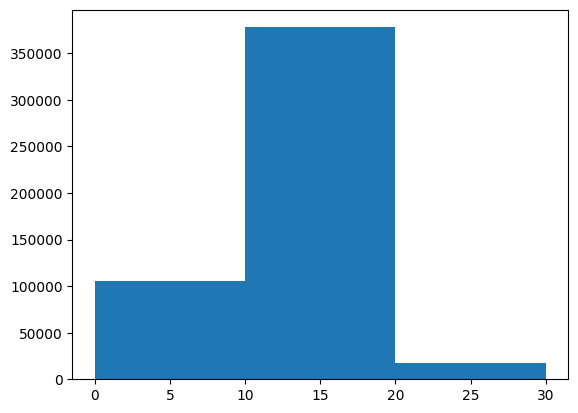

In [48]:
plt.hist(primaries, bins=bins)


0
10
(9785, 300)


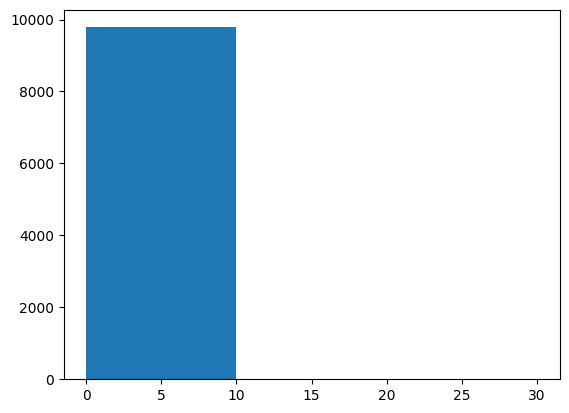


10
20
(9785, 300)


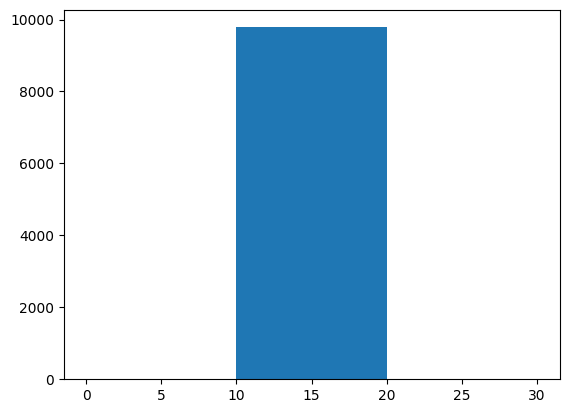


20
30
(9785, 300)


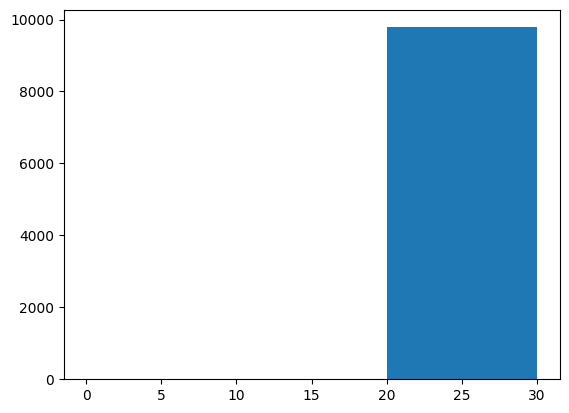

In [122]:
# Shuffle first
perm = np.random.permutation(len(data['wf_i']))
for k in data:
    data[k] = data[k][perm]

# Calculate primaries AFTER shuffling
primaries = np.sum(data['tag_values'] == 1, axis=1)

bins = np.arange(0, 31, 10)

n_per_bin = np.sum((primaries <= 30) & (primaries > 20))

uniform_data = {}
uniform_data['wf_i'] = []
uniform_data['tag_values'] = []

primaries = np.sum(data['tag_values'] == 1, axis=1)

for i in range(len(bins) - 1):
    currdata = {}
    print("")
    print(bins[i])
    print(bins[i+1])
    mask = (primaries < bins[i+1]) & (primaries >= bins[i])
    intermediate_tag = data['tag_values'][mask, :][:n_per_bin, :]
    intermediate_wf = data['wf_i'][mask, :][:n_per_bin, :]
    print(intermediate_tag.shape)
    uniform_data['wf_i'].append(intermediate_wf)
    uniform_data['tag_values'].append(intermediate_tag)
    curr_primaries = np.sum(intermediate_tag == 1, axis = 1)
    plt.hist(curr_primaries, bins=bins)
    plt.show()

uniform_data = {key: np.concatenate(arr_list, axis=0) for key, arr_list in uniform_data.items()}

uniform_primaries = np.sum(uniform_data['tag_values'] == 1, axis=1)

    

In [20]:
testdata = load_data(data_dir + "processed_data_test/",
                     ["batch_0.npz",
                      #"batch_1.npz",
                      #"batch_2.npz",
                      #"batch_3.npz",
                      #"batch_4.npz",
                    ])

if compress:
    compressed = []
    for i in range(testdata['wf_i'].shape[0]):
        wf_i = testdata['wf_i'][i]
        wf_i = wf_i.reshape(-1, compress_factor)
        wf_i = wf_i.mean(axis=1)

        compressed.append(wf_i)

    testdata['wf_i'] = np.asarray(compressed)

if truncate:
    testdata['wf_i'] = testdata['wf_i'][:,:num_timepoints]
    mask = testdata['tag_times'] >= num_timepoints
    testdata['tag_times'][mask] = 0
    testdata['tag_values'][mask] = 0
        

In [21]:
def make_corr_plot_test(actual, predicted):

    m, b = np.polyfit(actual[:10000], predicted[:10000], 1)
    correlation_coefficient, p_value = pearsonr(actual[:10000], predicted[:10000])
    x = np.arange(actual.min(), actual.max(), step=0.1)

    fig = plt.figure(figsize=(8, 6))
    plt.scatter(actual, predicted, s=30, alpha=0.2)
    plt.plot(x, m*x + b, color='red', label='Line of Best Fit')
    plt.xlabel('# Primaries in First Half of Waveform')
    plt.ylabel('# Primaries in Second Half of Waveform')
    plt.text(0.05,0.95, f"Correlation coefficient = {correlation_coefficient:.2f}", fontsize=12, color='black', 
             transform=plt.gca().transAxes,
             horizontalalignment='left',    
             verticalalignment='top', )
    plt.grid(True, color='gray', linestyle='--', alpha=0.4)
    plt.title('Correlation Between # Primaries in First and Second Half of Waveform')

In [22]:
print(data['wf_i'].shape)
print(data['mom'].shape)
print(data['tag_times'].shape)
print(data['tag_values'].shape)

(100000, 500)
(100000,)
(100000, 300)
(100000, 300)


In [23]:
def expand_values(values, times, tlength=3000, ohe=True, combine=False):
    # values: (300,)
    # times: (300,)
    data = np.zeros((num_timepoints,), dtype=np.float32)

    # Place values at the correct times
    valid_mask = (times >= 0) & (times < tlength)
    times = times[valid_mask]
    values = values[valid_mask]

    if truncate:
        mask = times >= num_timepoints
        times[mask] = 0
        values[mask] = 0

    data[times] = values
    
    if ohe:
        ohe_data = np.zeros((num_timepoints, 3), dtype=np.float32)
        for i in range(3):
            ohe_data[:, i] = (data == i).astype(np.float32)
        if combine:
            ohe_data[:, 1] = np.any(ohe_data[:, 1:], axis=-1)
            ohe_data[:, 2] = 0.0
        return ohe_data
    else:
        if combine:
            data = (data > 0).astype(np.float32)
        return data[:, None]  # shape (3000, 1)
    
def np_expand_values(values,times,tlength = 3000, ohe = True, combine = False):
    data = np.zeros((values.shape[0],tlength))
    data[np.arange(times.shape[0])[:,None],times] = values
    if ohe:
        data = np.concatenate([(data==i)[:,:,None] for i in range(3)],axis=-1).astype(np.float32)
        if combine:
            data[:,:,1] = np.any(data[:,:,1:],axis=-1)
            data[:,:,2] = 0.
    else:
        if combine:
            data = (data>0).astype(np.float32)
    return data

def batched_expand_values(values, times, batch_size=1000, tlength=3000, ohe=True, combine=False):
    outputs = []
    for i in tqdm(range(0, len(values), batch_size)):
        v_batch = values[i:i+batch_size]
        t_batch = times[i:i+batch_size]
        out = np_expand_values(v_batch, t_batch, tlength=tlength, ohe=ohe, combine=combine)
        outputs.append(out)
    return np.concatenate(outputs, axis=0)

In [24]:
test = expand_values(data['tag_values'],data['tag_times'],data['wf_i'].shape[1])
print(test.shape)

(500, 3)


In [25]:
import matplotlib.pyplot as plt

In [26]:
import tensorflow as tf
from tensorflow import keras
# Import tf/keras modules
from keras.layers import Dense
from keras.layers import Input
# This clears the Keras session
tf.keras.backend.clear_session()

2025-09-29 19:16:17.652543: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-29 19:16:17.666960: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
import os, sys

def load_npz_individual(file_path_bytes):
    path = file_path_bytes.decode("utf-8")
    data = np.load(path)

    # print(data)
    wf_i = data["wf_i"][:, :num_timepoints].astype(np.float32)      # (N, 3000)
    # print('wf shape ', wf_i.shape)
    tag_values = data["tag_values"]               # (N, ?)
    tag_times = data["tag_times"]                 # (N, ?)

    if truncate:
        mask = tag_times >= num_timepoints
        tag_times[mask] = 0
        tag_values[mask] = 0

    return wf_i, tag_values, tag_times

def build_dataset(file_list, batch_size, tlength=3000, ohe=True, combine=False, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices(file_list)

    def file_to_dataset(file_path):
        wf_i, tag_values, tag_times = tf.numpy_function(
            func=load_npz_individual,
            inp=[file_path],
            Tout=[tf.float32, tf.int32, tf.int32]
        )
        # Shapes are unknown, need to set
        wf_i.set_shape([None, num_timepoints])         # (N, 3000)

        if compress:
            wf_i = tf.reshape(wf_i, [tf.shape(wf_i)[0], -1, compress_factor])
            wf_i = tf.reduce_mean(wf_i, axis=-1)
            wf_i.set_shape([None, int(num_timepoints/compress_factor)]) 
  
        tag_values.set_shape([None, 300])     # (N, ?)
        tag_times.set_shape([None, 300])       # (N, ?)

        ex_ds = tf.data.Dataset.from_tensor_slices((wf_i, tag_values, tag_times))

        def process(wf_i_ex, tag_values_ex, tag_times_ex):
            # print(wf_i_ex)
            wf_i_ex = tf.expand_dims(wf_i_ex, axis=-1)  # (3000, 1)
            # print(tag_values_ex)
            boolean_tensor = tf.equal(tag_values_ex, 1)
            # print('boolean tensor ', boolean_tensor)
            y = tf.reduce_sum(tf.cast(boolean_tensor, tf.int32))

            print(y)
            if compress:
                wf_i_ex.set_shape([int(num_timepoints/compress_factor), 1])

            else:
                wf_i_ex.set_shape([num_timepoints, 1])
                
            return wf_i_ex, y
        

        return ex_ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)

    #if shuffle:
    #    ds = ds.shuffle(len(file_list))

    ds = ds.flat_map(file_to_dataset)
    ds = ds.shuffle(512)  # shuffle individual examples
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [28]:
from sklearn.model_selection import train_test_split
import glob

batchSize = 64

# Load file paths
file_list = sorted(glob.glob(data_dir + "processed_data_train/*.npz"))
train_files, val_files = train_test_split(file_list, test_size=0.2, shuffle=False)

train_ds = build_dataset(train_files, batchSize)
val_ds = build_dataset(val_files, batchSize, shuffle=False)

Tensor("Sum:0", shape=(), dtype=int32)
Tensor("Sum:0", shape=(), dtype=int32)


In [29]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 500, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [30]:
# Convert the dataset to a single NumPy array for features and labels
all_features = []
all_labels = []
count = 0
# Using a for-loop for more explicit control
for feature_batch, label_batch in train_ds.as_numpy_iterator():
    if count > 1562:
        break
    all_features.append(feature_batch)
    all_labels.append(label_batch)
    count += 1

features_np = np.concatenate(all_features, axis=0)
labels_np = np.concatenate(all_labels, axis=0)


(array([2.4900e+02, 3.8330e+03, 1.6959e+04, 3.0672e+04, 2.7996e+04,
        1.4540e+04, 4.6660e+03, 9.5700e+02, 1.4400e+02, 1.6000e+01]),
 array([ 1. ,  3.9,  6.8,  9.7, 12.6, 15.5, 18.4, 21.3, 24.2, 27.1, 30. ]),
 <BarContainer object of 10 artists>)

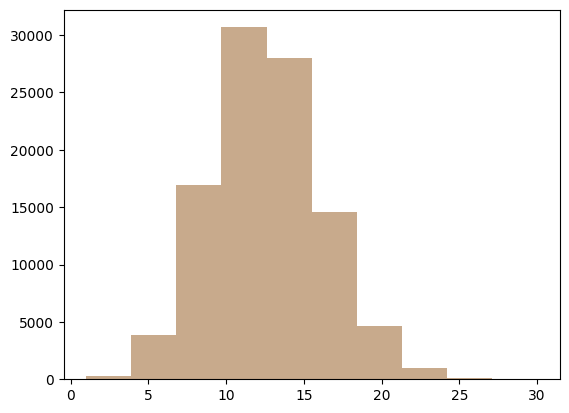

In [31]:
import matplotlib.pyplot as plt
plt.hist(np.sum((data['tag_values'] == 1).astype(np.int32), axis = 1), alpha = 0.4)
plt.hist(labels_np, alpha = 0.4)

In [32]:
np.sum((data['tag_values'] == 1).astype(np.int32), axis = 1)

array([17, 12, 14, ..., 20, 12, 12])

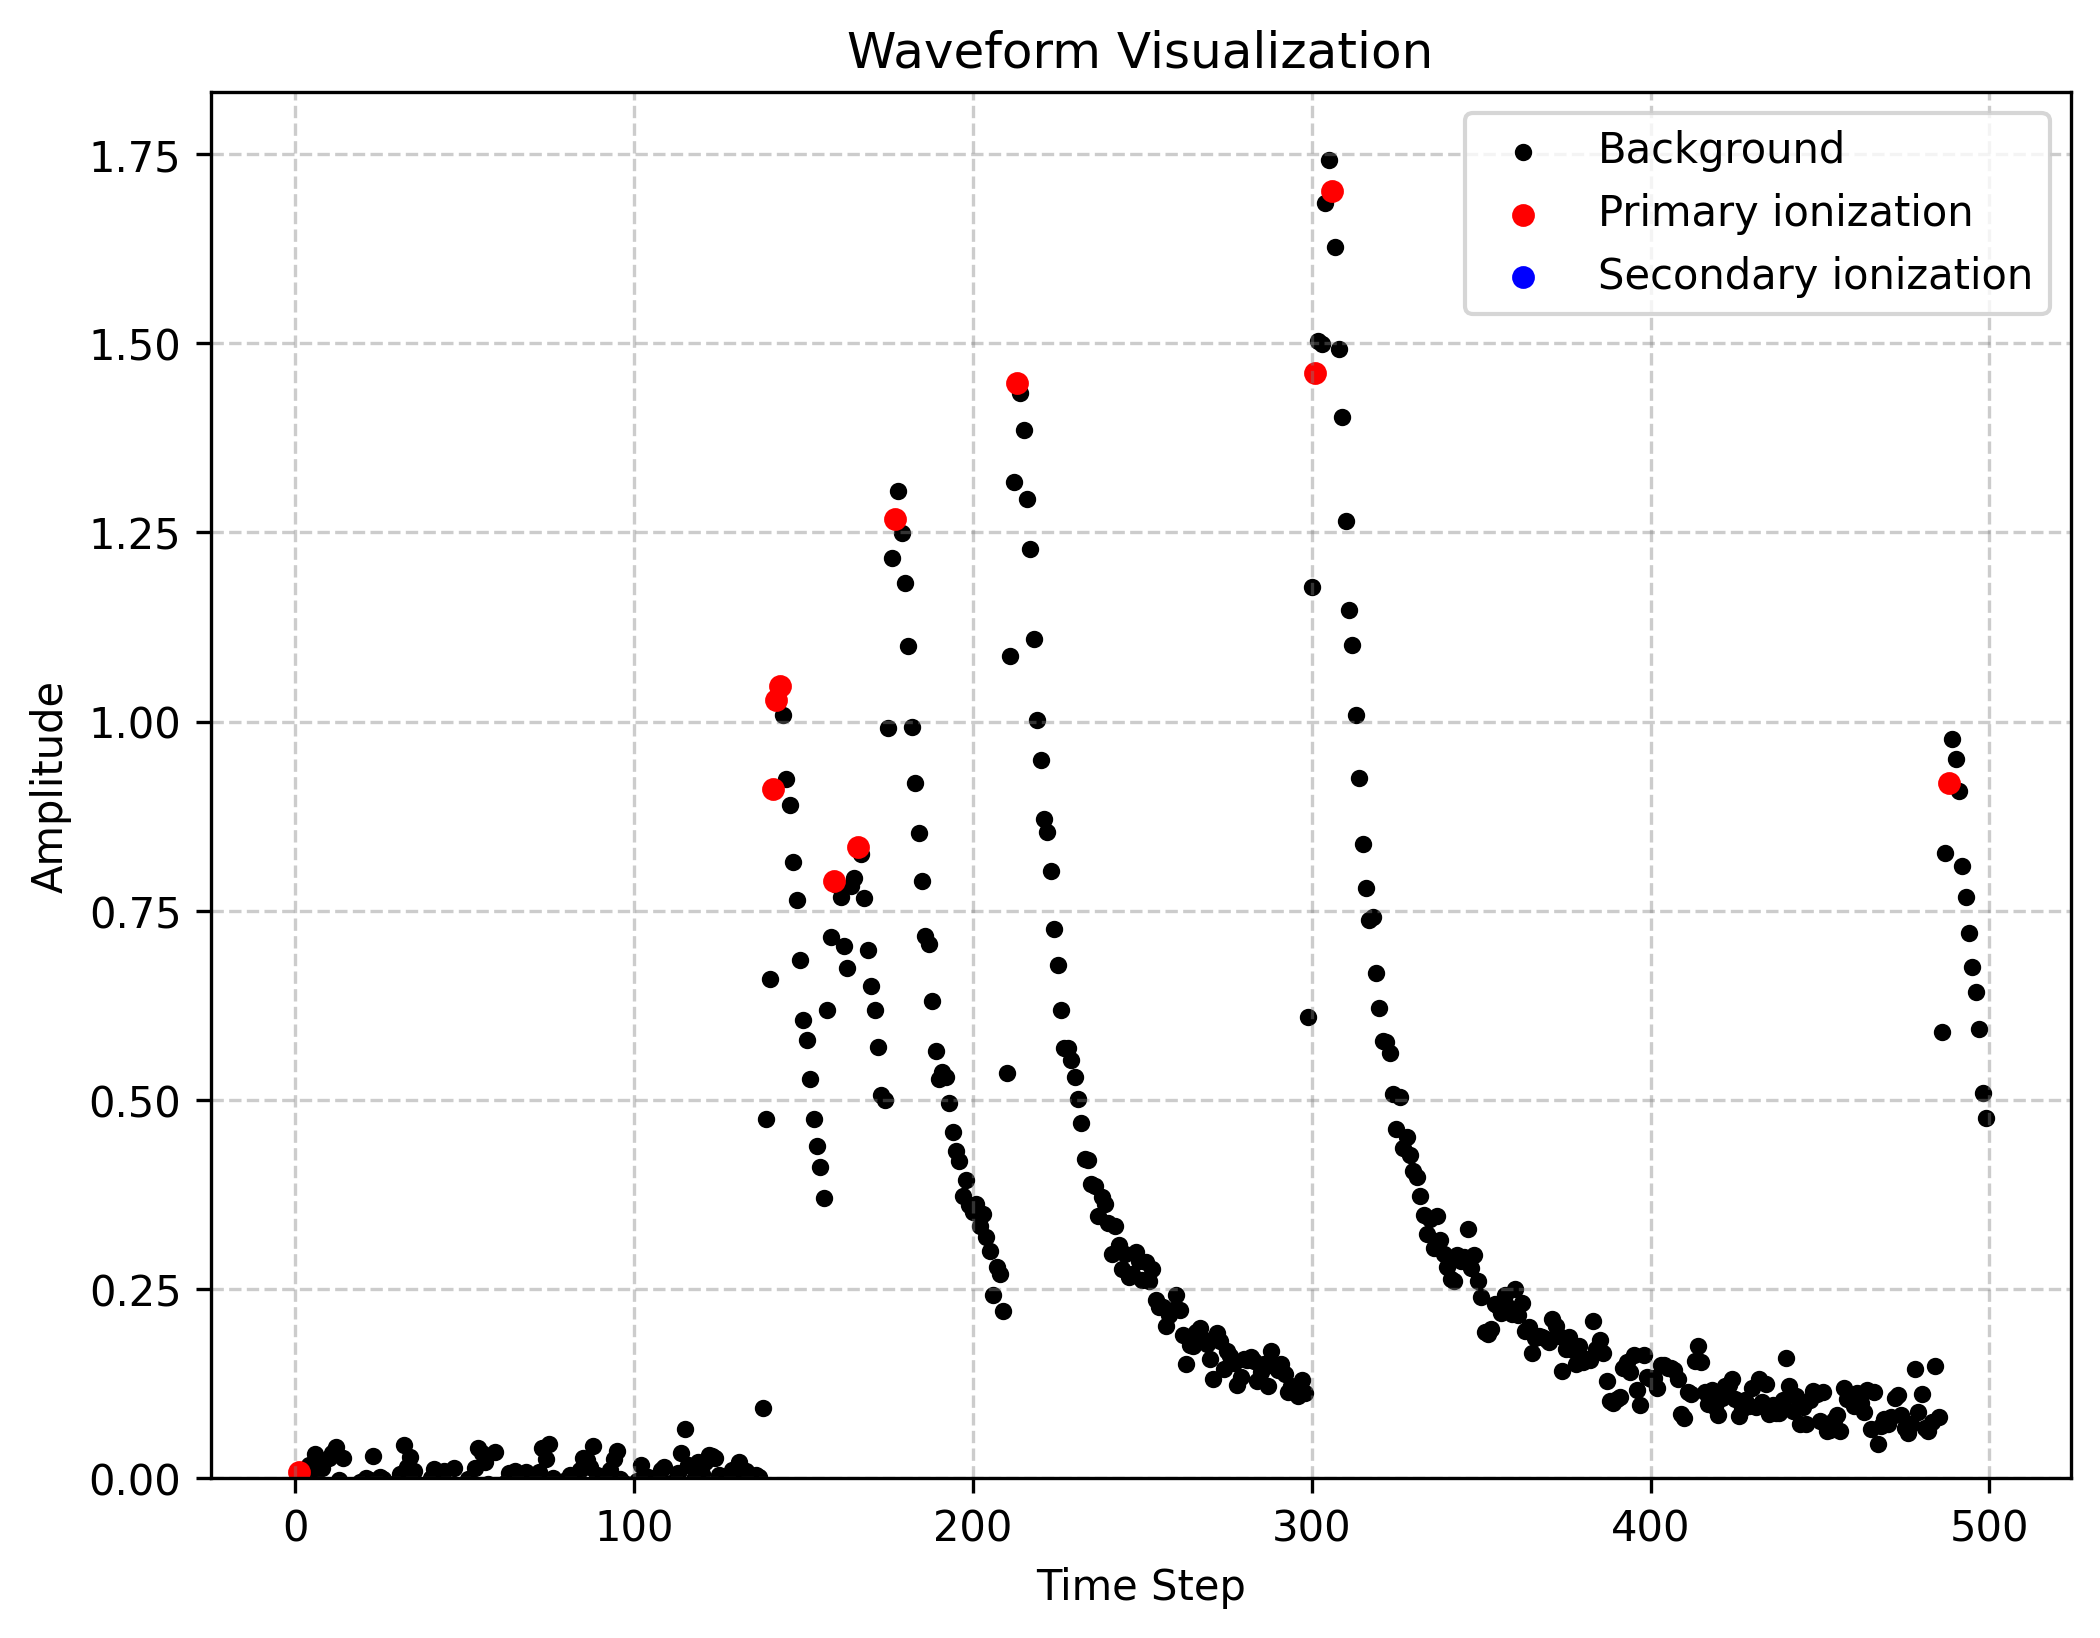

In [33]:
import matplotlib.pyplot as plt
iev = 4
plt.figure(figsize=(8, 6), dpi=300)
plt.scatter(np.arange(data['wf_i'][iev].shape[0]),data['wf_i'][iev],s=10, color='black', label='Background')
plt.scatter(data['tag_times'][iev,data['tag_values'][iev]==1],data['wf_i'][iev][data['tag_times'][iev,data['tag_values'][iev]==1]],s=20,color='r', label='Primary ionization')
plt.scatter(data['tag_times'][iev,data['tag_values'][iev]==2],data['wf_i'][iev][data['tag_times'][iev,data['tag_values'][iev]==2]],s=20,color='blue', label='Secondary ionization')
plt.xlabel("Time Step")
plt.ylabel("Amplitude")
plt.title("Waveform Visualization")
plt.grid(True, linestyle='--', color='gray', alpha = 0.4)
plt.legend()
plt.ylim(0)
plt.savefig(results_dir + 'waveform.png')

# Create and train model

### Trying uniform distribution for # primaries

In [135]:
import keras
from keras.layers import Dense, Input, AveragePooling1D, Reshape, GlobalAveragePooling1D, MaxPooling1D, Flatten

tf.random.set_seed(42)
np.random.seed(42)

def create_model():
    inputs = Input(shape=(int(num_timepoints/compress_factor),))
    x = inputs
    # x = Dense(64, activation="relu")(x)
    x = Dense(8, activation="relu")(x)
    x = Dense(32, activation="relu")(x)
    # x = Dense(1, activation="relu")(x)
    x = Dense(8, activation="relu")(x)
    # # x = MaxPooling1D(100)(x)
    # # x = Flatten()(x)
    # # x = Reshape((1,))(x)
    x = Dense(1,activation='linear')(x)
    outputs = x

    return keras.Model(inputs=inputs, outputs=outputs, name="DNN")

model = create_model()
model.summary()

Model: "DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 500)]             0         
                                                                 
 dense_20 (Dense)            (None, 8)                 4008      
                                                                 
 dense_21 (Dense)            (None, 32)                288       
                                                                 
 dense_22 (Dense)            (None, 8)                 264       
                                                                 
 dense_23 (Dense)            (None, 1)                 9         
                                                                 
Total params: 4569 (17.85 KB)
Trainable params: 4569 (17.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [137]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.optimizers import Adam

loss_fn = tf.keras.losses.MeanSquaredError()
batchSize = 16
nEpochs = 750
learningRate = 6e-4

earlystop = EarlyStopping(
        monitor="val_loss", 
        patience=50,
        restore_best_weights=True,
        min_delta=0.0, 
    )

reducelr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=50,
    min_delta=0.,
    min_lr=1.e-7,
)

# dndxgru = dndx_gru(gru_c1layers,gru_rlayers,gru_c2layers,gru_dlayers)

print(model.summary())
# Define Optimizer and compile
opt = Adam(learning_rate=learningRate)
model.compile(loss=loss_fn, optimizer=opt,
    metrics=tf.keras.metrics.MeanAbsoluteError(name='mae'))


history = model.fit(uniform_data['wf_i'], uniform_primaries,
                    batch_size=batchSize, 
                    epochs=nEpochs, 
                    callbacks=(earlystop, reducelr),
                    validation_split=0.2)  # Use 20% of training data for validation

model.save(model_dir + 'DNN_8_32_8_uniform_dist.keras')

Model: "DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 500)]             0         
                                                                 
 dense_20 (Dense)            (None, 8)                 4008      
                                                                 
 dense_21 (Dense)            (None, 32)                288       
                                                                 
 dense_22 (Dense)            (None, 8)                 264       
                                                                 
 dense_23 (Dense)            (None, 1)                 9         
                                                                 
Total params: 4569 (17.85 KB)
Trainable params: 4569 (17.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/750
1468/1468 [=

#### Performance plots

3125/3125 [==============================] - 1s 324us/step


<Figure size 2400x1800 with 0 Axes>

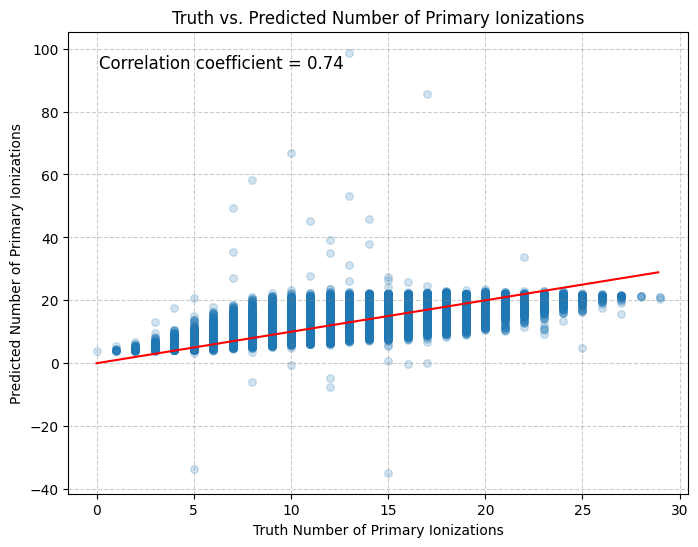

In [138]:
ntest = 100000

plt.figure(figsize=(8, 6), dpi=300)
preds = np.asarray(model.predict(testdata['wf_i']))[:ntest].reshape(ntest)
actual = np.asarray(np.sum(testdata['tag_values'] == 1, axis = 1))[:ntest].reshape(ntest)

make_corr_plot(actual, preds)
plt.savefig(results_dir +'corr_plot.png', dpi=300)



Text(0, 0.5, 'Frequency')

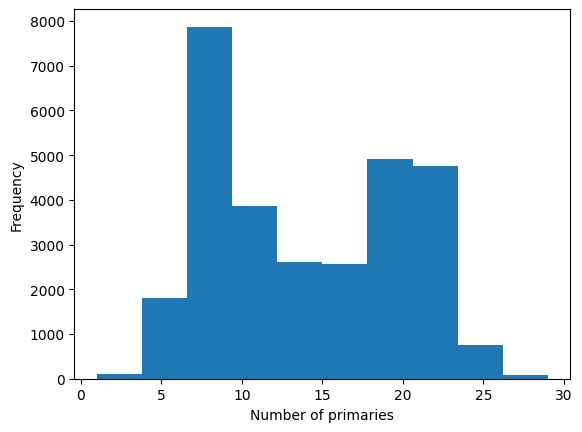

In [146]:
# bins = np.arange(0,31,10)
plt.hist(uniform_primaries)
plt.xlabel('Number of primaries')
plt.ylabel('Frequency')

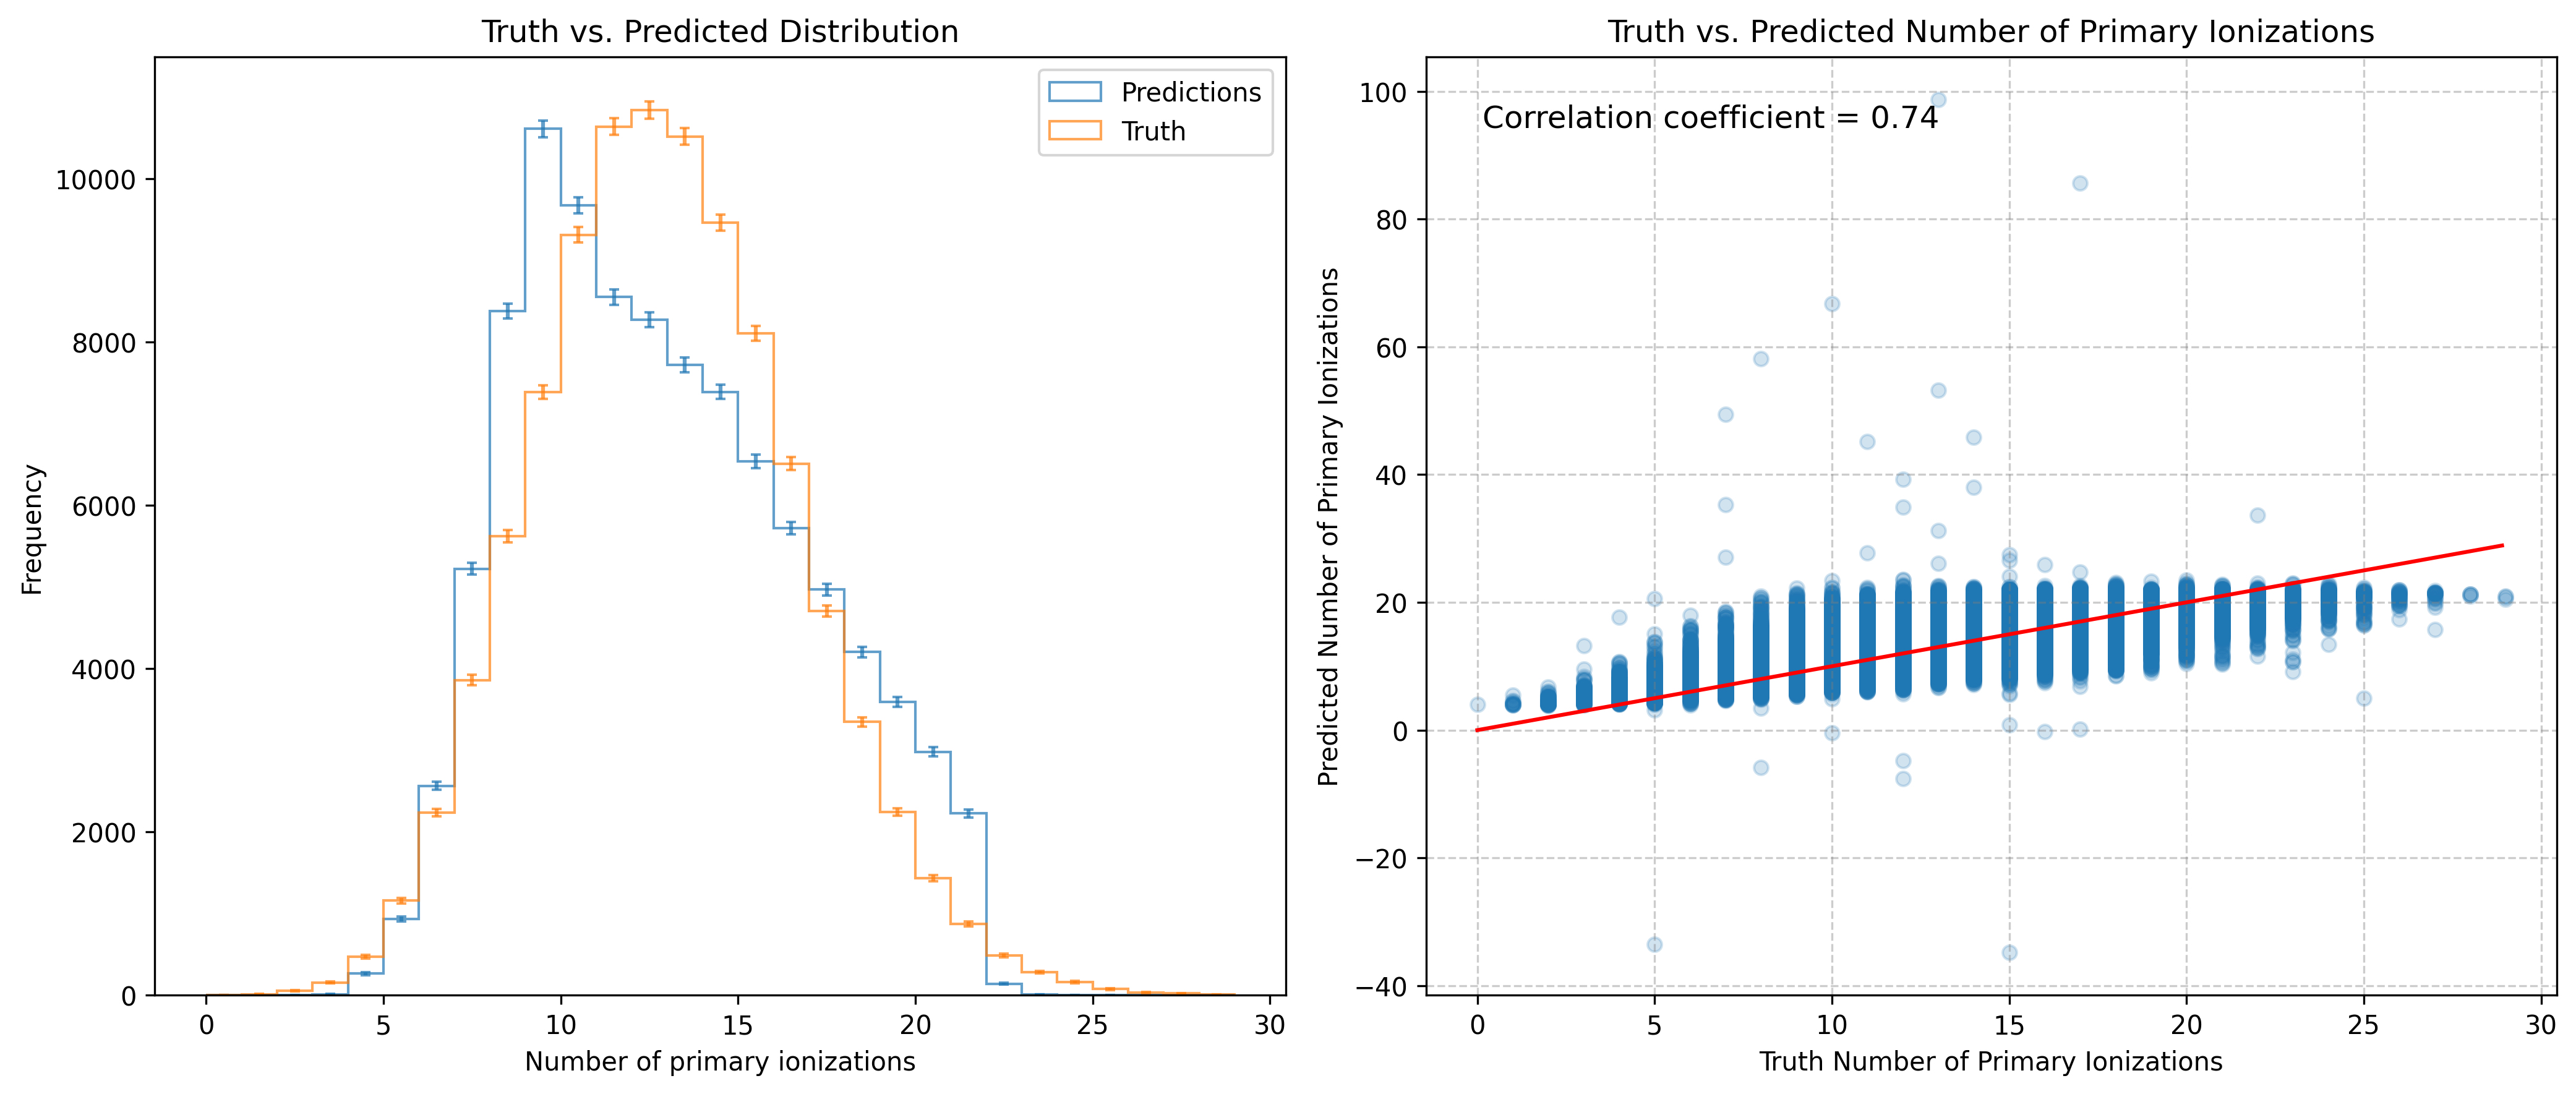

In [139]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6), dpi=300)

# Left subplot: Histogram comparison
bins = np.arange(30)

# Plot histograms and get counts for error bars
pred_counts, pred_bins, pred_patches = axes[0].hist(preds, bins=bins, histtype='step', label='Predictions', alpha=0.7)
truth_counts, truth_bins, truth_patches = axes[0].hist(np.sum(testdata['tag_values']==1, axis=-1), bins=bins, histtype='step', label='Truth', alpha=0.7)

# Add error bars
bin_centers = (bins[:-1] + bins[1:]) / 2
axes[0].errorbar(bin_centers, pred_counts, yerr=np.sqrt(pred_counts), 
                 fmt='none', capsize=2, color=pred_patches[0].get_edgecolor())
axes[0].errorbar(bin_centers, truth_counts, yerr=np.sqrt(truth_counts), 
                 fmt='none', capsize=2, color=truth_patches[0].get_edgecolor())

axes[0].legend()
axes[0].set_xlabel("Number of primary ionizations")
axes[0].set_ylabel("Frequency")
axes[0].set_title('Truth vs. Predicted Distribution')

# Right subplot: Correlation scatter plot
actual = np.sum(testdata['tag_values']==1, axis=-1)  # Make sure this matches your truth data
predicted = preds
m = 1
b = 0
correlation_coefficient, p_value = pearsonr(actual[:10000], predicted[:10000])
x = np.arange(actual.min(), actual.max(), step=0.1)

axes[1].scatter(actual, predicted, s=30, alpha=0.2)
axes[1].plot(x, m*x + b, color='red')
axes[1].set_xlabel('Truth Number of Primary Ionizations')
axes[1].set_ylabel('Predicted Number of Primary Ionizations')
axes[1].text(0.05, 0.95, f"Correlation coefficient = {correlation_coefficient:.2f}", 
             fontsize=12, color='black', 
             transform=axes[1].transAxes,
             horizontalalignment='left',    
             verticalalignment='top')
axes[1].grid(True, color='gray', linestyle='--', alpha=0.4)
axes[1].set_title('Truth vs. Predicted Number of Primary Ionizations')

plt.tight_layout()
plt.show()
fig.savefig(results_dir + 'model_performance.png')

3125/3125 [==============================] - 1s 304us/step


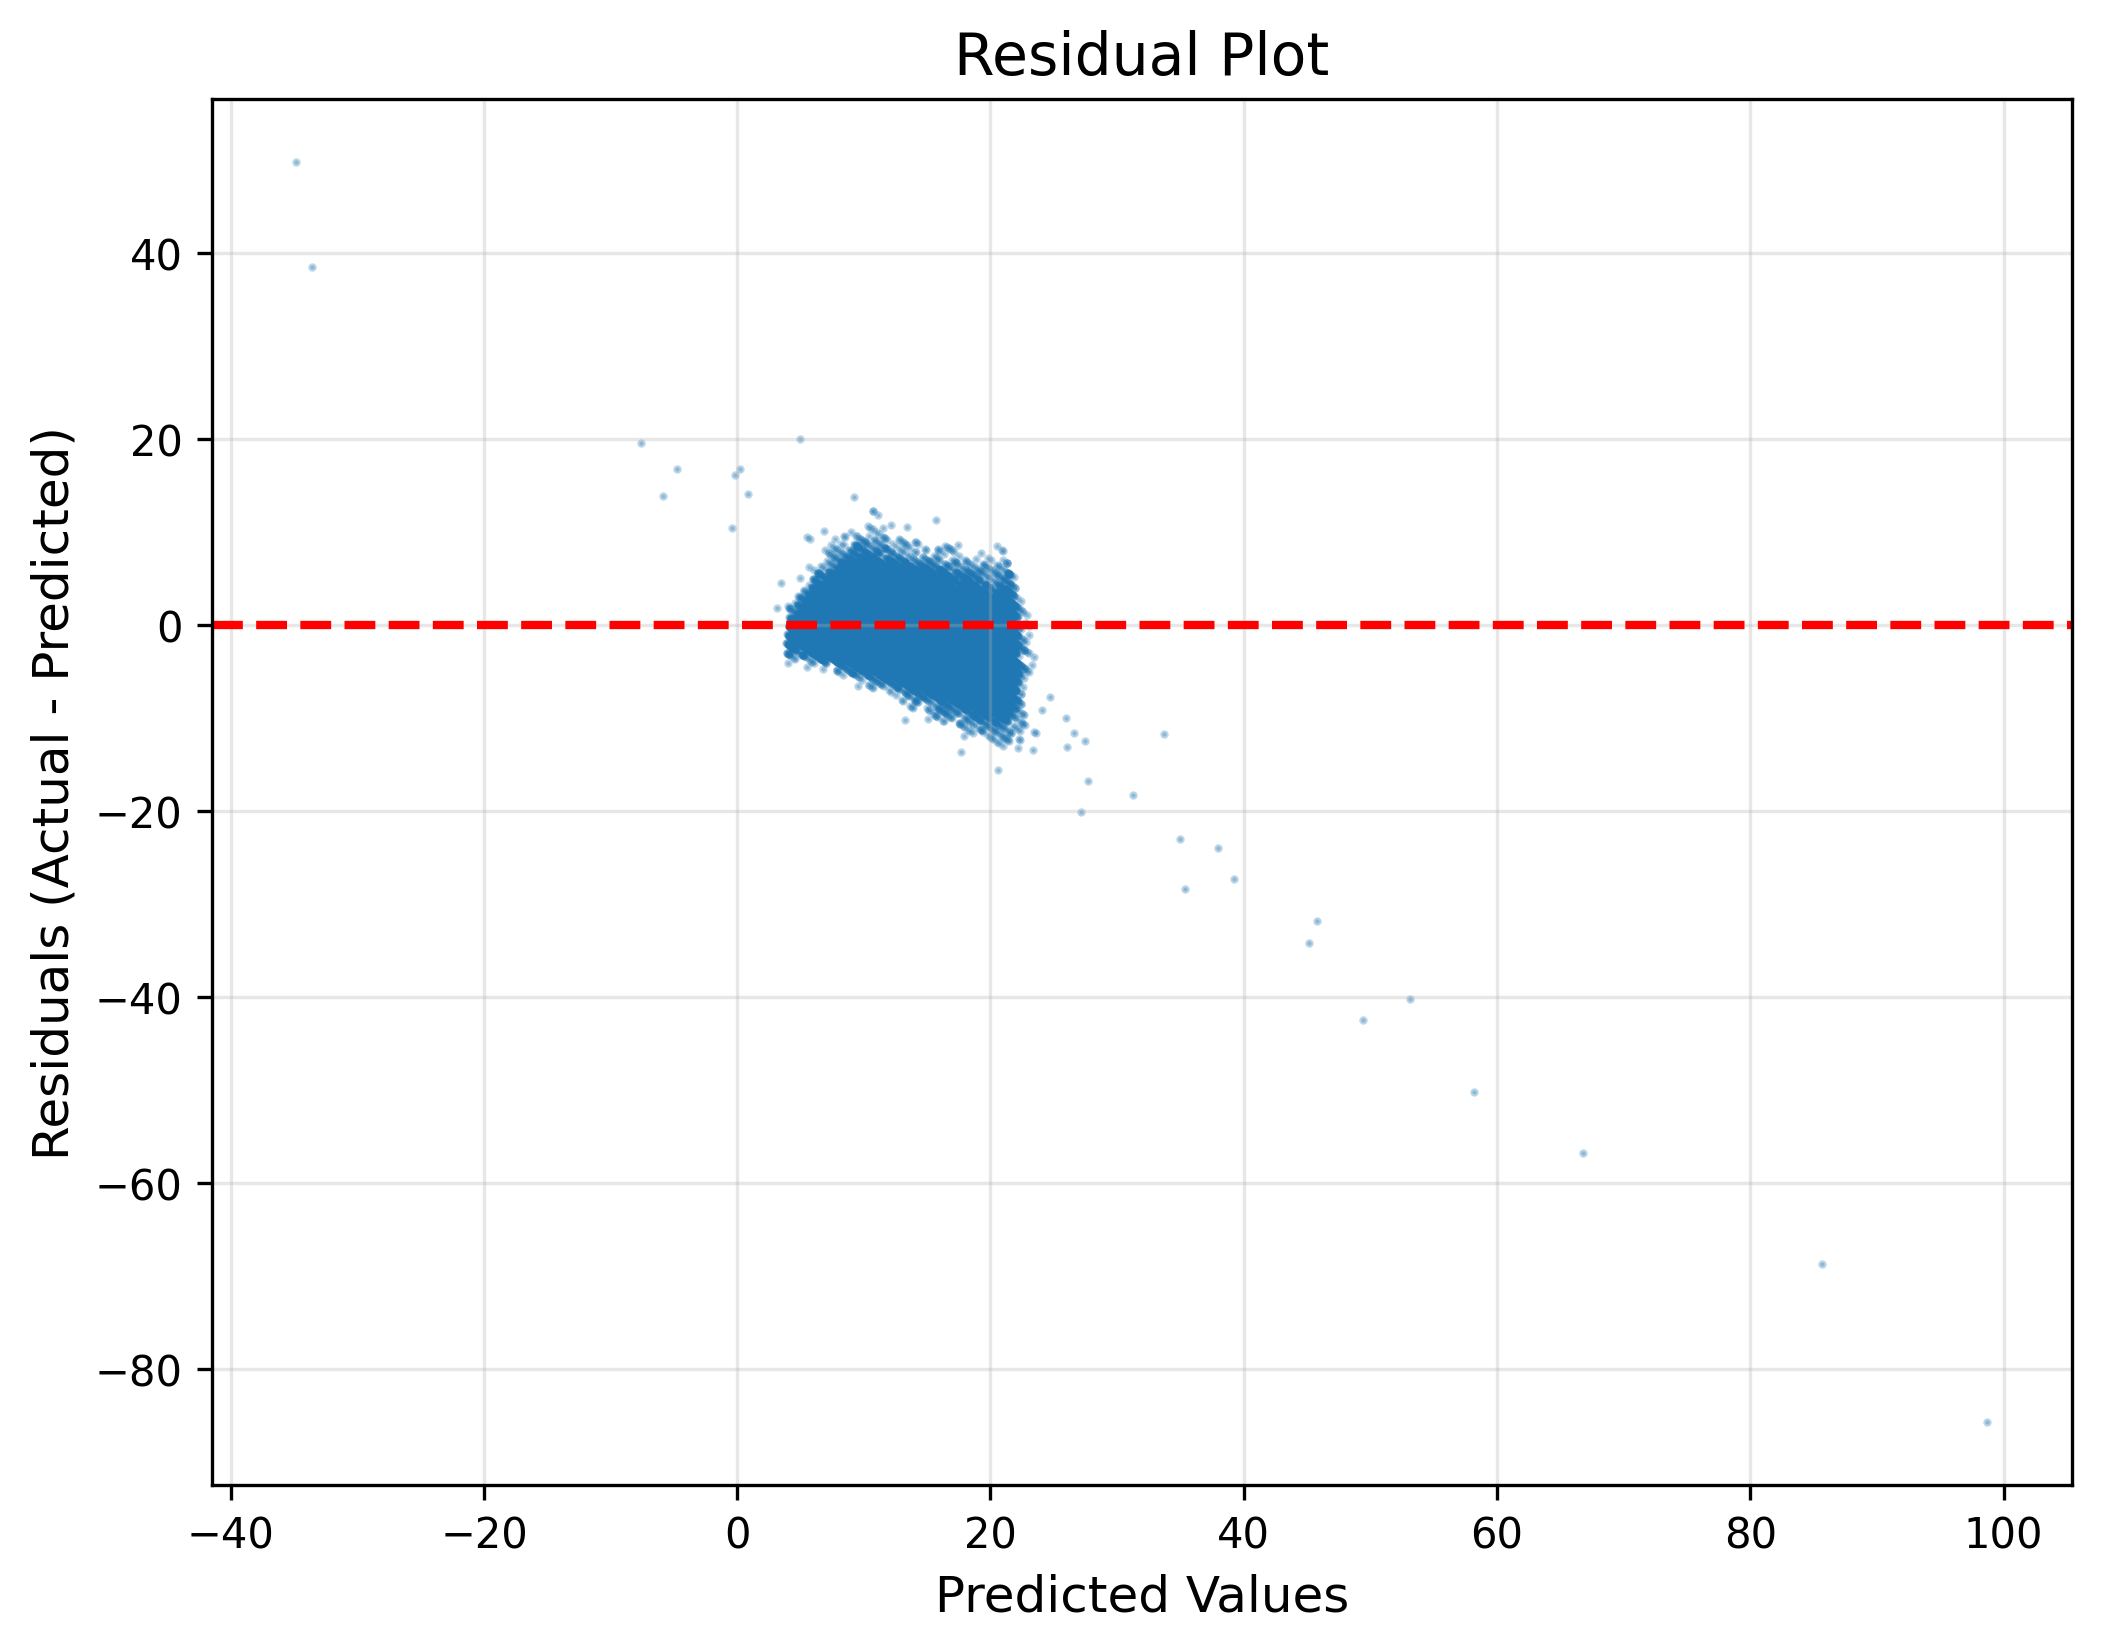

In [140]:
ntest = 100000

plt.figure(figsize=(8, 6), dpi=300)
preds = np.asarray(model.predict(testdata['wf_i']))[:ntest].reshape(ntest)
actual = np.asarray(np.sum(testdata['tag_values'] == 1, axis = 1))[:ntest].reshape(ntest)

# Calculate residuals
residuals = actual - preds

# Create residual plot
plt.scatter(preds, residuals, alpha=0.3, s=1)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Residuals (Actual - Predicted)', fontsize=12)
plt.title('Residual Plot', fontsize=14)
plt.grid(True, alpha=0.3)
plt.savefig(results_dir + 'residual_plot.png', dpi=300, bbox_inches='tight')
plt.show()

### DNN

In [31]:
import keras
from keras.layers import Dense, Input, AveragePooling1D, Reshape, GlobalAveragePooling1D, MaxPooling1D, Flatten

tf.random.set_seed(42)
np.random.seed(42)

def create_model():
    inputs = Input(shape=(int(num_timepoints/compress_factor),))
    x = inputs
    # x = Dense(64, activation="relu")(x)
    x = Dense(8, activation="relu")(x)
    x = Dense(32, activation="relu")(x)
    # x = Dense(1, activation="relu")(x)
    x = Dense(8, activation="relu")(x)
    # # x = MaxPooling1D(100)(x)
    # # x = Flatten()(x)
    # # x = Reshape((1,))(x)
    x = Dense(1,activation='linear')(x)
    outputs = x

    return keras.Model(inputs=inputs, outputs=outputs, name="DNN")

model = create_model()
model.summary()

Model: "DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 500)]             0         
                                                                 
 dense_24 (Dense)            (None, 8)                 4008      
                                                                 
 dense_25 (Dense)            (None, 32)                288       
                                                                 
 dense_26 (Dense)            (None, 8)                 264       
                                                                 
 dense_27 (Dense)            (None, 1)                 9         
                                                                 
Total params: 4569 (17.85 KB)
Trainable params: 4569 (17.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.optimizers import Adam

loss_fn = tf.keras.losses.MeanSquaredError()
batchSize = 64
nEpochs = 75
learningRate = 6e-4

earlystop = EarlyStopping(
        monitor="val_loss", 
        patience=10,
        restore_best_weights=True,
        min_delta=0.0, 
    )

reducelr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=5,
    min_delta=0.,
    min_lr=1.e-7,
)

# dndxgru = dndx_gru(gru_c1layers,gru_rlayers,gru_c2layers,gru_dlayers)

print(model.summary())
# Define Optimizer and compile
opt = Adam(learning_rate=learningRate)
model.compile(loss=loss_fn, optimizer=opt,
    metrics=tf.keras.metrics.MeanAbsoluteError(name='mae'))


history = model.fit(train_ds, validation_data=val_ds,
                    batch_size=batchSize, epochs=nEpochs, callbacks=(earlystop,reducelr))

model.save(model_dir + 'DNN_8_32_8_v2.keras')

Model: "DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 500)]             0         
                                                                 
 dense_24 (Dense)            (None, 8)                 4008      
                                                                 
 dense_25 (Dense)            (None, 32)                288       
                                                                 
 dense_26 (Dense)            (None, 8)                 264       
                                                                 
 dense_27 (Dense)            (None, 1)                 9         
                                                                 
Total params: 4569 (17.85 KB)
Trainable params: 4569 (17.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/75
6250/6250 [==

In [ ]:
def create_and_train_model(learningRate):
    model = create_model()
    print(model.summary())

    loss_fn = tf.keras.losses.MeanSquaredError()
    batchSize = 64
    nEpochs = 10

    earlystop = EarlyStopping(
            monitor="val_loss", 
            patience=10,
            restore_best_weights=True,
            min_delta=0.0, 
        )

    reducelr = ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=3,
        min_delta=0.,
        min_lr=1.e-7,
    )

    # Define Optimizer and compile
    opt = Adam(learning_rate=learningRate)
    model.compile(loss=loss_fn, optimizer=opt,
        metrics=tf.keras.metrics.MeanAbsoluteError(name='mae'))

    history = model.fit(train_ds, validation_data=val_ds,
                      batch_size=batchSize, epochs=nEpochs, callbacks=(earlystop,reducelr))

    return model

In [ ]:
learningRates = [1e-4, 2e-4, 3e-4, 5e-4, 6e-4, 7e-4, 8e-4, 9e-4, 10e-4]
mse = []

for lr in learningRates:
    print(f"Training model with learning rate: {lr}")
    model = create_and_train_model(lr)
    model.save(f'models/500_dense_8_32_8_lr_{lr}.keras')
    print(f"Model saved for learning rate: {lr}")
    mse.append(model.evaluate(val_ds, verbose=0)[0])


Training model with learning rate: 0.0001
Model: "DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 500)]             0         
                                                                 
 dense_20 (Dense)            (None, 8)                 4008      
                                                                 
 dense_21 (Dense)            (None, 32)                288       
                                                                 
 dense_22 (Dense)            (None, 8)                 264       
                                                                 
 dense_23 (Dense)            (None, 1)                 9         
                                                                 
Total params: 4569 (17.85 KB)
Trainable params: 4569 (17.85 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________________________________________

None
Epoch 1/10
6250/6250 [==============================] - 25s 3ms/step - loss: 116.6720 - mae: 9.7260 - val_loss: 77.4239 - val_mae: 7.6174 - lr: 1.0000e-04
Epoch 2/10
6250/6250 [==============================] - 25s 3ms/step - loss: 35.4853 - mae: 4.6279 - val_loss: 12.0208 - val_mae: 2.3304 - lr: 1.0000e-04
Epoch 3/10
6250/6250 [==============================] - 25s 3ms/step - loss: 8.7829 - mae: 2.1556 - val_loss: 7.7260 - val_mae: 2.0602 - lr: 1.0000e-04
Epoch 4/10
6250/6250 [==============================] - 25s 3ms/step - loss: 7.5984 - mae: 2.0583 - val_loss: 7.0039 - val_mae: 2.0218 - lr: 1.0000e-04
Epoch 5/10
6250/6250 [==============================] - 25s 3ms/step - loss: 7.1040 - mae: 2.0266 - val_loss: 6.7205 - val_mae: 1.9979 - lr: 1.0000e-04
Epoch 6/10
6250/6250 [==============================] - 25s 3ms/step - loss: 6.8455 - mae: 2.0030 - val_loss: 6.5280 - val_mae: 1.9773 - lr: 1.0000e-04
Epoch 7/10
6250/6250 [==============================] - 25s 3ms/step - loss: 6

In [ ]:
mse = [6.006002426147461,
 5.931219577789307,
 5.733735084533691,
 5.602978706359863,
 5.6904706954956055,
 5.3071112632751465,
 5.5545148849487305,
 5.480565547943115,
 5.785809516906738]

# learningRates = [1e-2, 3.16e-3, 1e-3, 3.16e-4, 1e-4, 3.16e-5]

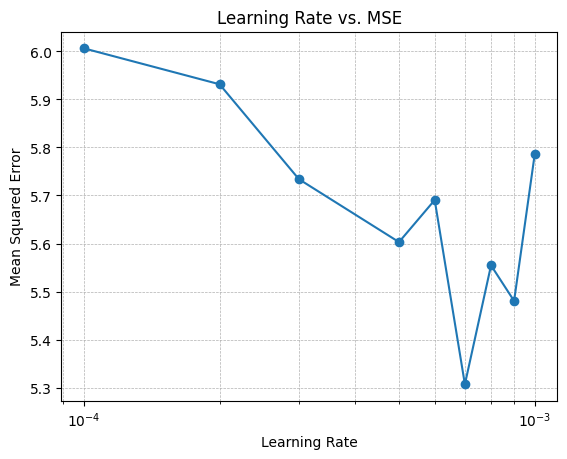

In [ ]:
import matplotlib.pyplot as plt
# learningRates = [1e-2, 3.16e-3, 1e-3, 3.16e-4, 1e-4, 3.16e-5, 1e-5, 3.16e-6, 1e-6]
plt.plot(learningRates, mse, marker='o')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Mean Squared Error')
plt.title('Learning Rate vs. MSE')
plt.grid(True, which='both', linestyle='--', linewidth=0.5) 

### CNN

In [21]:
import keras
import tensorflow as tf
from keras.layers import Conv1D, MaxPooling1D, Dense, Input, Flatten, GlobalAveragePooling1D, GlobalMaxPool1D, GRU, Reshape, Conv1DTranspose, UpSampling1D, Normalization, Dropout
 
def create_model(c1layers=[[32,1,1,'valid',False]], dlayers=[32,32]):
    inputs = Input(shape=(int(num_timepoints/compress_factor),1))
    x = inputs
    # x = Normalization()(x)
    npool = 0
    for i,c in enumerate(c1layers):
        x = Conv1D(c[0],c[1],c[2],padding=c[3],activation="relu")(x)
        if c[4]:
            x = MaxPooling1D(5)(x)
            npool = npool+1
            

    x = GlobalAveragePooling1D()(x)
    
    for i,d in enumerate(dlayers):
        x = Dense(d,activation="relu")(x)

    # x = Dropout(0.25)(x)

    # x = Conv1D(1, 4, 1, activation = 'linear')(x)

    # outputs = Reshape((1,))(x)
        
    outputs = Dense(1,activation='linear')(x)
    
    return keras.Model(inputs=inputs, outputs=outputs, name="cnn-regressor")
 
 
c1layers=[[16,5,5,'same',False], [16,5,1,'same',False], [16,5,1,'same',False]]
dlayers=[32, 32]
model = create_model(c1layers, dlayers)
 
print(model.summary())

Model: "cnn-regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 100, 16)           96        
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 16)           1296      
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 16)           1296      
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 32)                544       
                                                     

In [22]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.optimizers import Adam

loss_fn = tf.keras.losses.MeanSquaredError()
batchSize = 32
nEpochs = 100
learningRate = 1e-3

earlystop = EarlyStopping(
        monitor="val_loss", 
        patience=10,
        restore_best_weights=True,
        min_delta=0.0, 
    )

reducelr = ReduceLROnPlateau(
    monitor="loss",
    factor=0.2,
    patience=3,
    min_delta=0.,
    min_lr=1.e-7,
)

# dndxgru = dndx_gru(gru_c1layers,gru_rlayers,gru_c2layers,gru_dlayers)

print(model.summary())
# Define Optimizer and compile
opt = Adam(learning_rate=learningRate)
model.compile(loss=loss_fn, optimizer=opt,
    metrics=tf.keras.metrics.MeanAbsoluteError(name='mae'))

train = True
if train:
    history = model.fit(train_ds, validation_data=val_ds,
                      batch_size=batchSize, epochs=nEpochs, callbacks=(earlystop,reducelr))

    # model.save('models/norm_cf_4_no_GAP_3conv.keras')
else:
    model = keras.models.load_model('models/dndxgru_%s.keras'%(label+grulabel))

Model: "cnn-regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 100, 16)           96        
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 16)           1296      
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 16)           1296      
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 32)                544       
                                                     

KeyboardInterrupt: 

In [23]:
model.save(model_dir + 'cnn.keras')

### Hyperparameter tuning

In [ ]:
import keras_tuner as kt

In [ ]:
import keras
from keras.layers import Conv1D, MaxPooling1D, Dense, Input, Flatten, GlobalAveragePooling1D, GRU, Reshape, Conv1DTranspose, UpSampling1D
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.optimizers import Adam

def create_model(hp): 
    inputs = Input(shape=(int(num_timepoints/compress_factor),))
    x = inputs  

    x = Dense(8, activation='relu')(x)

    for i in range(1,4):
        x = Dense(units=hp.Int(f'dense_units_{i+1}', min_value=5, max_value=35, step=5), activation="relu")(x)
    
    x = Dense(1, activation='linear')(x)

    outputs = x

    model = keras.Model(inputs=inputs, outputs=outputs, name="gru")

    hp_learning_rate = hp.Float('learning_rate', min_value=1e-6, max_value=1e-2, sampling='log', default=1e-3)

    loss_fn = tf.keras.losses.MeanSquaredError()
    opt = Adam(learning_rate=hp_learning_rate)
    model.compile(loss=loss_fn, optimizer=opt,
        metrics=tf.keras.metrics.MeanSquaredError(name='mse')) 
    
    return model



In [ ]:
nEpochs = 10

earlystop = EarlyStopping(
        monitor="val_loss", 
        patience=10,
        restore_best_weights=True,
        min_delta=0.0, 
    )

reducelr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=2,
    min_delta=0.,
    min_lr=1.e-7,
)

tuner = kt.Hyperband(
    hypermodel=create_model,
    objective=kt.Objective('val_mse',direction="min"), # Optimize for validation recall (important for imbalanced data)
    max_epochs=50,          # Max epochs to train any model during the search
    factor=3,               # Reduction factor for the number of models and epochs
    directory='my_tuning_dir_500_dense_v2', # Directory to store results
    project_name='focal_loss_tuning' # Name of the tuning project
)

batchSize = 64 # Fixed batch size for all trials in this example

tuner.search(train_ds,
             epochs=nEpochs, # Use your nEpochs from your script
             batch_size=batchSize, # Pass batch size here
             validation_data=val_ds,
             callbacks=[earlystop, reducelr])

Trial 75 Complete [00h 06m 35s]
val_mse: 5.329287052154541

Best val_mse So Far: 5.167749881744385
Total elapsed time: 2d 07h 14m 10s

Search: Running Trial #76

Value             |Best Value So Far |Hyperparameter
30                |15                |dense_units_2
20                |35                |dense_units_3
15                |15                |dense_units_4
2.333e-06         |0.00061595        |learning_rate
17                |50                |tuner/epochs
0                 |17                |tuner/initial_epoch
1                 |3                 |tuner/bracket
0                 |3                 |tuner/round

Epoch 1/17
6250/6250 [==============================] - 24s 3ms/step - loss: 161.5976 - mse: 161.5976 - val_loss: 150.5580 - val_mse: 150.5580 - lr: 2.3330e-06
Epoch 2/17
6250/6250 [==============================] - 24s 3ms/step - loss: 147.2692 - mse: 147.2692 - val_loss: 144.1132 - val_mse: 144.1132 - lr: 2.3330e-06
Epoch 3/17
6250/6250 [=======================

2025-08-10 20:54:14.022588: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1 of 512
2025-08-10 20:54:14.025310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


6250/6250 [==============================] - 41s 5ms/step - loss: 137.5671 - mse: 137.5671 - val_loss: 135.0781 - val_mse: 135.0781 - lr: 2.3330e-06
Epoch 5/17
6250/6250 [==============================] - 26s 3ms/step - loss: 132.8642 - mse: 132.8642 - val_loss: 130.2687 - val_mse: 130.2687 - lr: 2.3330e-06
Epoch 6/17
6250/6250 [==============================] - 24s 3ms/step - loss: 128.2373 - mse: 128.2373 - val_loss: 125.4545 - val_mse: 125.4545 - lr: 2.3330e-06
Epoch 7/17
6250/6250 [==============================] - 23s 3ms/step - loss: 123.5408 - mse: 123.5408 - val_loss: 120.5348 - val_mse: 120.5348 - lr: 2.3330e-06
Epoch 8/17
6250/6250 [==============================] - 24s 3ms/step - loss: 118.7773 - mse: 118.7773 - val_loss: 115.4642 - val_mse: 115.4642 - lr: 2.3330e-06
Epoch 9/17
6250/6250 [==============================] - 23s 3ms/step - loss: 113.9383 - mse: 113.9383 - val_loss: 110.3532 - val_mse: 110.3532 - lr: 2.3330e-06
Epoch 10/17
6250/6250 [============================

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"\nBest Hyperparameters found:")
print(f"  Learning Rate: {best_hps.get('learning_rate'):.6f}")
print(f"  Num Dense layers: {best_hps.get('num_dense_layers')}")
print(f"  Dense Conv Units Layer 1: {best_hps.get('dense_units_1')}")
print(f"  Dense Conv Units Layer 2: {best_hps.get('dense_units_2')}")
print(f"  Dense Conv Units Layer 3: {best_hps.get('dense_units_3')}")


best_model = tuner.get_best_models(num_models=1)[0]

print("\n--- Best Model Summary ---")
best_model.summary()


Best Hyperparameters found:
  Learning Rate: 0.000631
  Num Dense layers: 3
  Dense Conv Units Layer 1: 25
  Dense Conv Units Layer 2: 25
  Dense Conv Units Layer 3: 15

--- Best Model Summary ---
Model: "gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 dense (Dense)               (None, 25)                12525     
                                                                 
 dense_1 (Dense)             (None, 25)                650       
                                                                 
 dense_2 (Dense)             (None, 15)                390       
                                                                 
 dense_3 (Dense)             (None, 1)                 16        
                                                               

In [ ]:
model.save('models/500_tiniest_possible')

INFO:tensorflow:Assets written to: models/500_tiniest_possible/assets


INFO:tensorflow:Assets written to: models/500_tiniest_possible/assets


In [ ]:
model.save('models/500_dense.keras')

In [ ]:
from keras.layers import Conv1D, MaxPooling1D, Dense, Input, Flatten, GlobalAveragePooling1D, GlobalMaxPool1D, GRU, Reshape, Conv1DTranspose, UpSampling1D
 
def create_model(c1layers=[[32,1,1,'valid',False]], dlayers=[32,32]):
    inputs = Input(shape=(3000,1))
    x = inputs
    npool = 0
    for i,c in enumerate(c1layers):
        x = Conv1D(c[0],c[1],c[2],padding=c[3],activation="relu")(x)
        if c[4]:
            x = MaxPooling1D(5)(x)
            npool = npool+1
    
    # x = MaxPooling1D(60)(x)
    x = Flatten()(x)
    
    for i,d in enumerate(dlayers):
        x = Dense(d,activation="relu")(x)
        
    outputs = Dense(1,activation='linear')(x)
    
    return keras.Model(inputs=inputs, outputs=outputs, name="cnn-regressor")
 
 
c1layers=[[8,500,5,'same',True], [8,5,1,'same',True]]
dlayers=[16, 32]
model = create_model(c1layers, dlayers)
 
print(model.summary())

Model: "cnn-regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 3000, 1)]         0         
                                                                 
 conv1d_6 (Conv1D)           (None, 600, 8)            4008      
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 120, 8)            0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 120, 8)            328       
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 24, 8)             0         
 g1D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 192)             

In [ ]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.optimizers import Adam

loss_fn = tf.keras.losses.MeanSquaredError()
batchSize = 64
nEpochs = 25
learningRate = 1e-2

earlystop = EarlyStopping(
        monitor="val_loss", 
        patience=10,
        restore_best_weights=True,
        min_delta=0.0, 
    )

reducelr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_delta=0.,
    min_lr=1.e-7,
)

# dndxgru = dndx_gru(gru_c1layers,gru_rlayers,gru_c2layers,gru_dlayers)

print(model.summary())
# Define Optimizer and compile
opt = Adam(learning_rate=learningRate)
model.compile(loss=loss_fn, optimizer=opt,
    metrics=tf.keras.metrics.MeanAbsoluteError(name='mae'))

if doGRUTrain:
    history = model.fit(train_ds, validation_data=val_ds,
                      batch_size=batchSize, epochs=nEpochs, callbacks=(earlystop,reducelr))

    model.save('models/v2_regression_dndxgru_focal.keras')
else:
    model = keras.models.load_model('models/dndxgru_%s.keras'%(label+grulabel))

Model: "cnn-regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 3000, 1)]         0         
                                                                 
 conv1d_6 (Conv1D)           (None, 600, 8)            4008      
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 120, 8)            0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 120, 8)            328       
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 24, 8)             0         
 g1D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 192)             

KeyboardInterrupt: 

In [ ]:
model.save('models/v2_conv_max_pooling.keras')

In [ ]:
model = keras.models.load_model('models/regression_dndxgru_focal.keras')

### Plots

In [53]:
import keras
model = keras.models.load_model(model_dir + 'DNN_8_32_8.keras')

#### Downsampling plot

In [ ]:
import keras
from pathlib import Path

ntest = 100000
dir = 'models/lrreduced_tiny_denses'
model_paths = [str(p.resolve()) for p in Path(dir).rglob('*') if p.is_file()]

perc_error_mean = []
perc_error_std = []
compress_factors = []

for model_path in model_paths:
    print('Current path: ', (model_path.split('/')[-1]))
    compress_factor = int(model_path.split('/')[-1].split('_')[1])
    compress_factors.append(compress_factor)
    print(compress_factor)
    compress = True

    model = keras.models.load_model(model_path)

    testdata = load_data("./processed_data_test/",
                     ["batch_0.npz",
                      #"batch_1.npz",
                      #"batch_2.npz",
                      #"batch_3.npz",
                      #"batch_4.npz",
                    ])

    if compress:
        compressed = []
        for i in range(testdata['wf_i'].shape[0]):
            wf_i = testdata['wf_i'][i]
            wf_i = wf_i.reshape(-1, compress_factor)
            wf_i = wf_i.mean(axis=1)

            compressed.append(wf_i)

        testdata['wf_i'] = np.asarray(compressed)

    predicted = np.asarray(model.predict(testdata['wf_i']))[:ntest].reshape(ntest)
    actual = np.asarray(np.sum(testdata['tag_values'] == 1, axis = 1))[:ntest].reshape(ntest)

    error = ((predicted - actual)/actual) * 100

    mean = np.mean(error)
    std = np.std(error.astype(np.float32))

    perc_error_mean.append(mean)
    perc_error_std.append(std)
    


2025-07-30 23:56:59.032444: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-30 23:56:59.054110: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Current path:  cf_5_lrreduced_dense.keras
5
3125/3125 [==============================] - 1s 281us/step
Current path:  cf_10_lrreduced_dense.keras
10
3125/3125 [==============================] - 1s 280us/step
Current path:  cf_30_lrreduced_dense.keras
30
3125/3125 [==============================] - 1s 271us/step
Current path:  cf_8_lrreduced_dense.keras
8
3125/3125 [==============================] - 1s 306us/step
Current path:  cf_4_lrreduced_dense.keras
4
3125/3125 [==============================] - 1s 273us/step
Current path:  cf_3_lrreduced_dense.keras
3
3125/3125 [==============================] - 1s 275us/step
Current path:  cf_6_lrreduced_dense.keras
6
3125/3125 [==============================] - 1s 276us/step


In [ ]:
compress_factors = np.asarray(compress_factors)
perc_error_mean = np.asarray(perc_error_mean)
perc_error_std = np.asarray(perc_error_std)

Text(0.5, 1.0, 'Compress Factor vs. STD Percent Error')

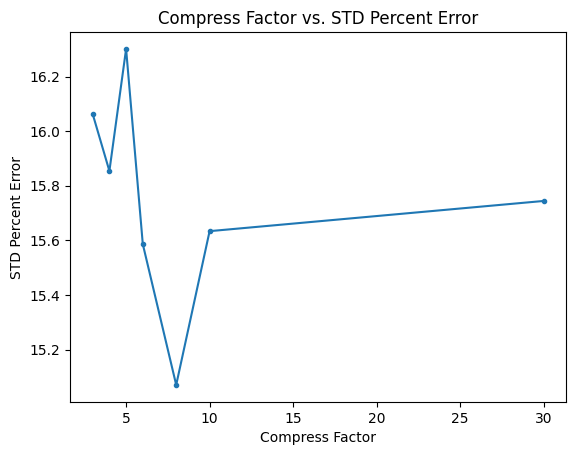

In [ ]:
plt.plot(np.sort(compress_factors), np.asarray(perc_error_std)[np.argsort(compress_factors)],ls='-', marker='.')
plt.xlabel('Compress Factor')
plt.ylabel('STD Percent Error')
plt.title('Compress Factor vs. STD Percent Error')

Text(0.5, 1.0, 'Compress Factor vs. Mean Percent Error')

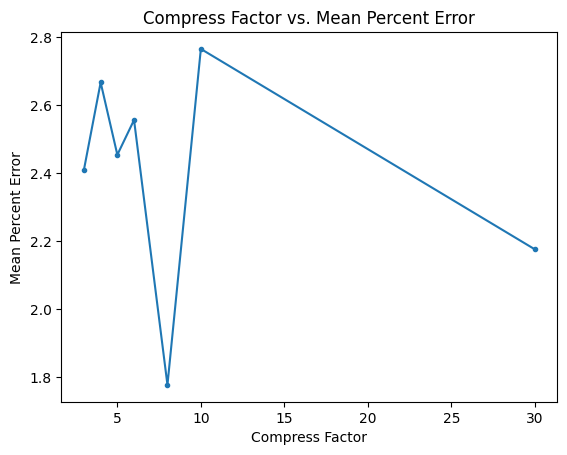

In [ ]:
plt.plot(np.sort(compress_factors), np.asarray(perc_error_mean)[np.argsort(compress_factors)],ls='-', marker='.')
plt.xlabel('Compress Factor')
plt.ylabel('Mean Percent Error')
plt.title('Compress Factor vs. Mean Percent Error')

#### Standard performance plots

In [24]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val loss')
plt.legend()

NameError: name 'history' is not defined

3125/3125 [==============================] - 2s 615us/step


<Figure size 2400x1800 with 0 Axes>

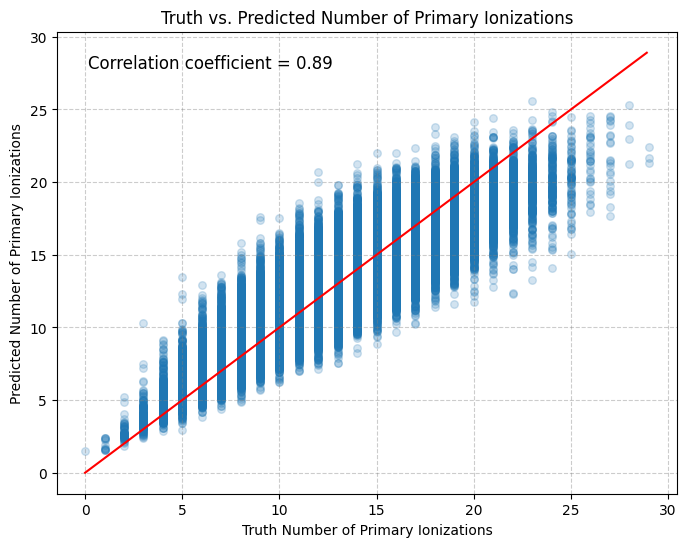

In [25]:
ntest = 100000

plt.figure(figsize=(8, 6), dpi=300)
preds = np.asarray(model.predict(testdata['wf_i']))[:ntest].reshape(ntest)
actual = np.asarray(np.sum(testdata['tag_values'] == 1, axis = 1))[:ntest].reshape(ntest)

make_corr_plot(actual, preds)
plt.savefig(results_dir +'corr_plot.png', dpi=300)



In [ ]:
np.sum(actual == 0).astype(np.int32)

1

In [ ]:
testdata['wf_i'].shape

(100000, 500)

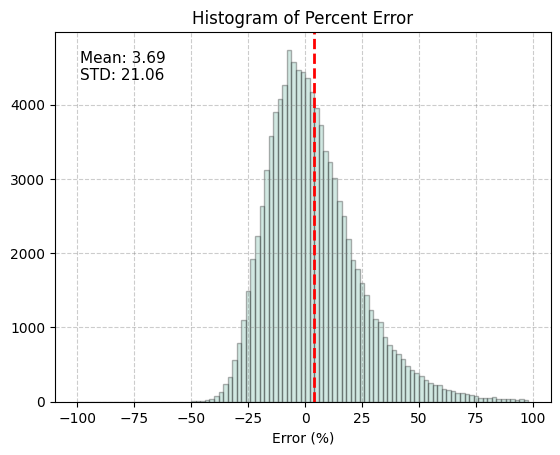

In [56]:
plot_percent_error(actual, preds)

Text(0.5, 1.0, 'Truth vs. Predicted Number of Primary Ionizations')

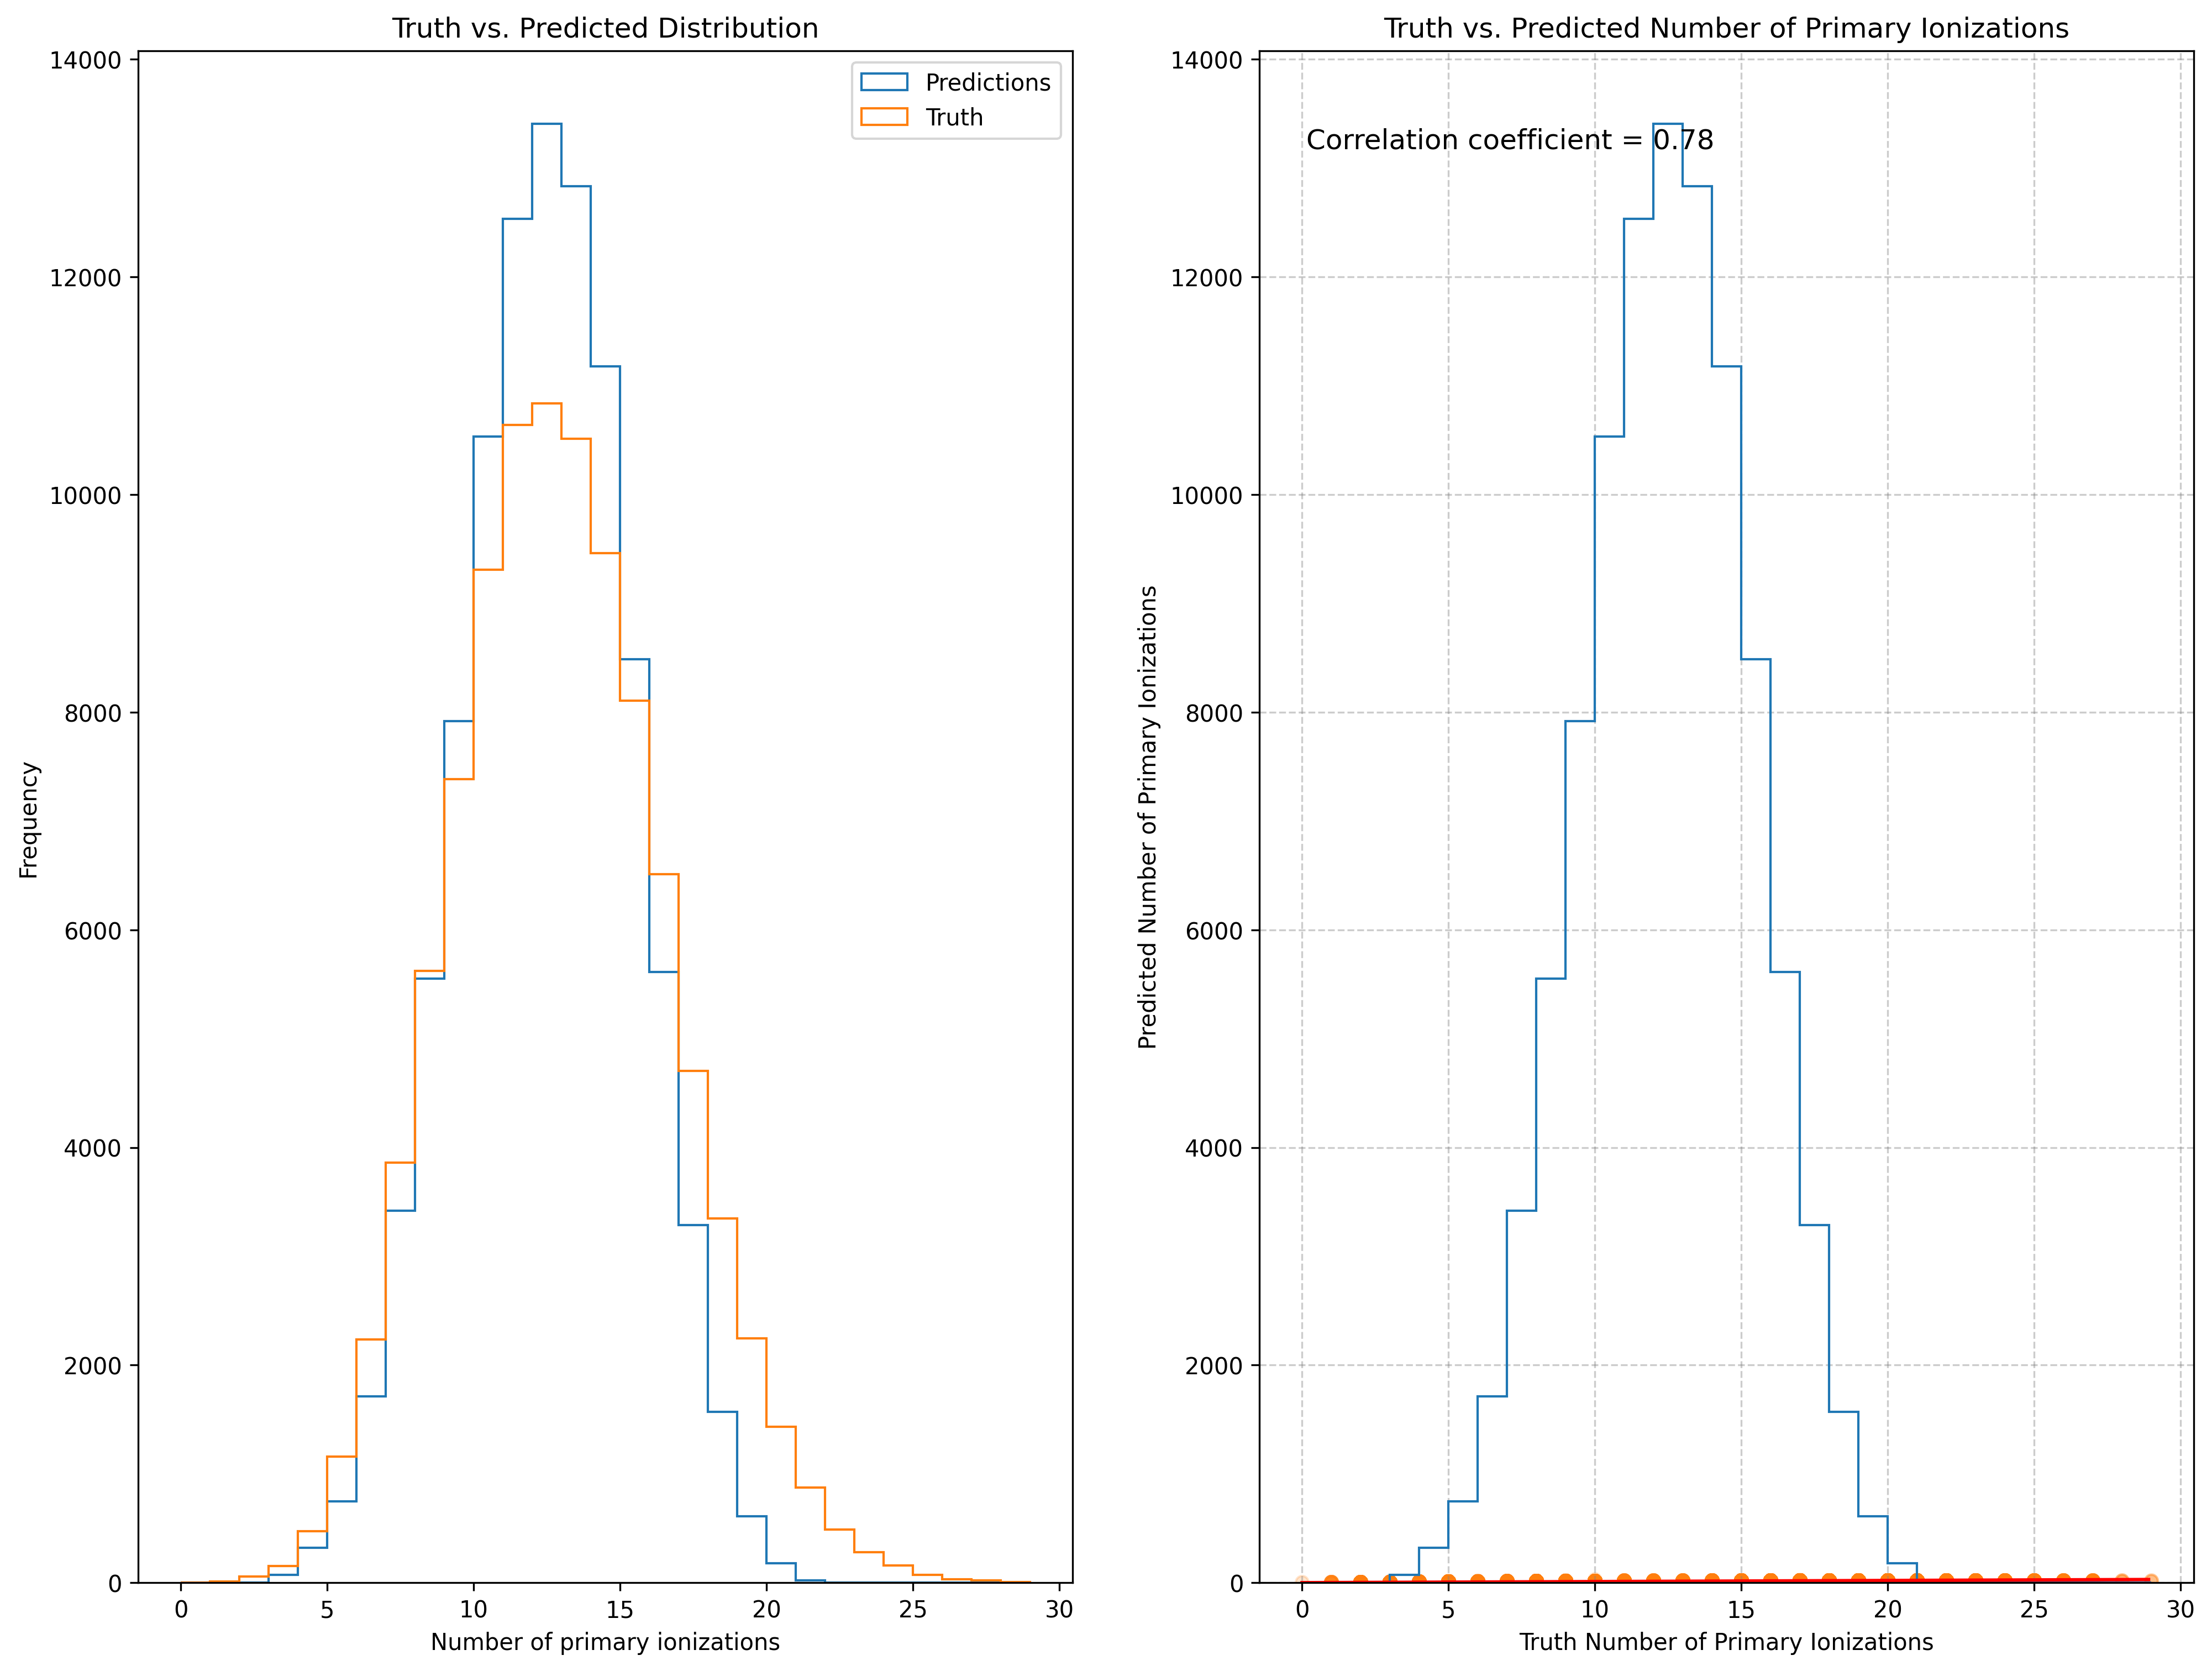

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 12), dpi = 300)

_,bins,_ = plt.hist(preds,bins=np.arange(30),histtype='step',label='Predictions')
axes[0].hist(preds,bins=np.arange(30),histtype='step',label='Predictions')
axes[0].hist(np.sum(testdata['tag_values']==1,axis=-1),bins=bins,histtype='step',label='Truth')
axes[0].legend()
axes[0].set_xlabel("Number of primary ionizations")
axes[0].set_ylabel("Frequency")
axes[0].set_title('Truth vs. Predicted Distribution')


actual = actual
predicted = preds
m = 1
b = 0
correlation_coefficient, p_value = pearsonr(actual[:100000], predicted[:100000])
x = np.arange(actual.min(), actual.max(), step=0.1)

axes[1].scatter(actual, predicted, s=30, alpha=0.2)
axes[1].plot(x, m*x + b, color='red')
axes[1].set_xlabel('Truth Number of Primary Ionizations')
axes[1].set_ylabel('Predicted Number of Primary Ionizations')
axes[1].text(0.05,0.95, f"Correlation coefficient = {correlation_coefficient:.2f}", fontsize=12, color='black', 
            transform=axes[1].transAxes,
            horizontalalignment='left',    
            verticalalignment='top', )
axes[1].grid(True, color='gray', linestyle='--', alpha=0.4)
axes[1].set_title('Truth vs. Predicted Number of Primary Ionizations')



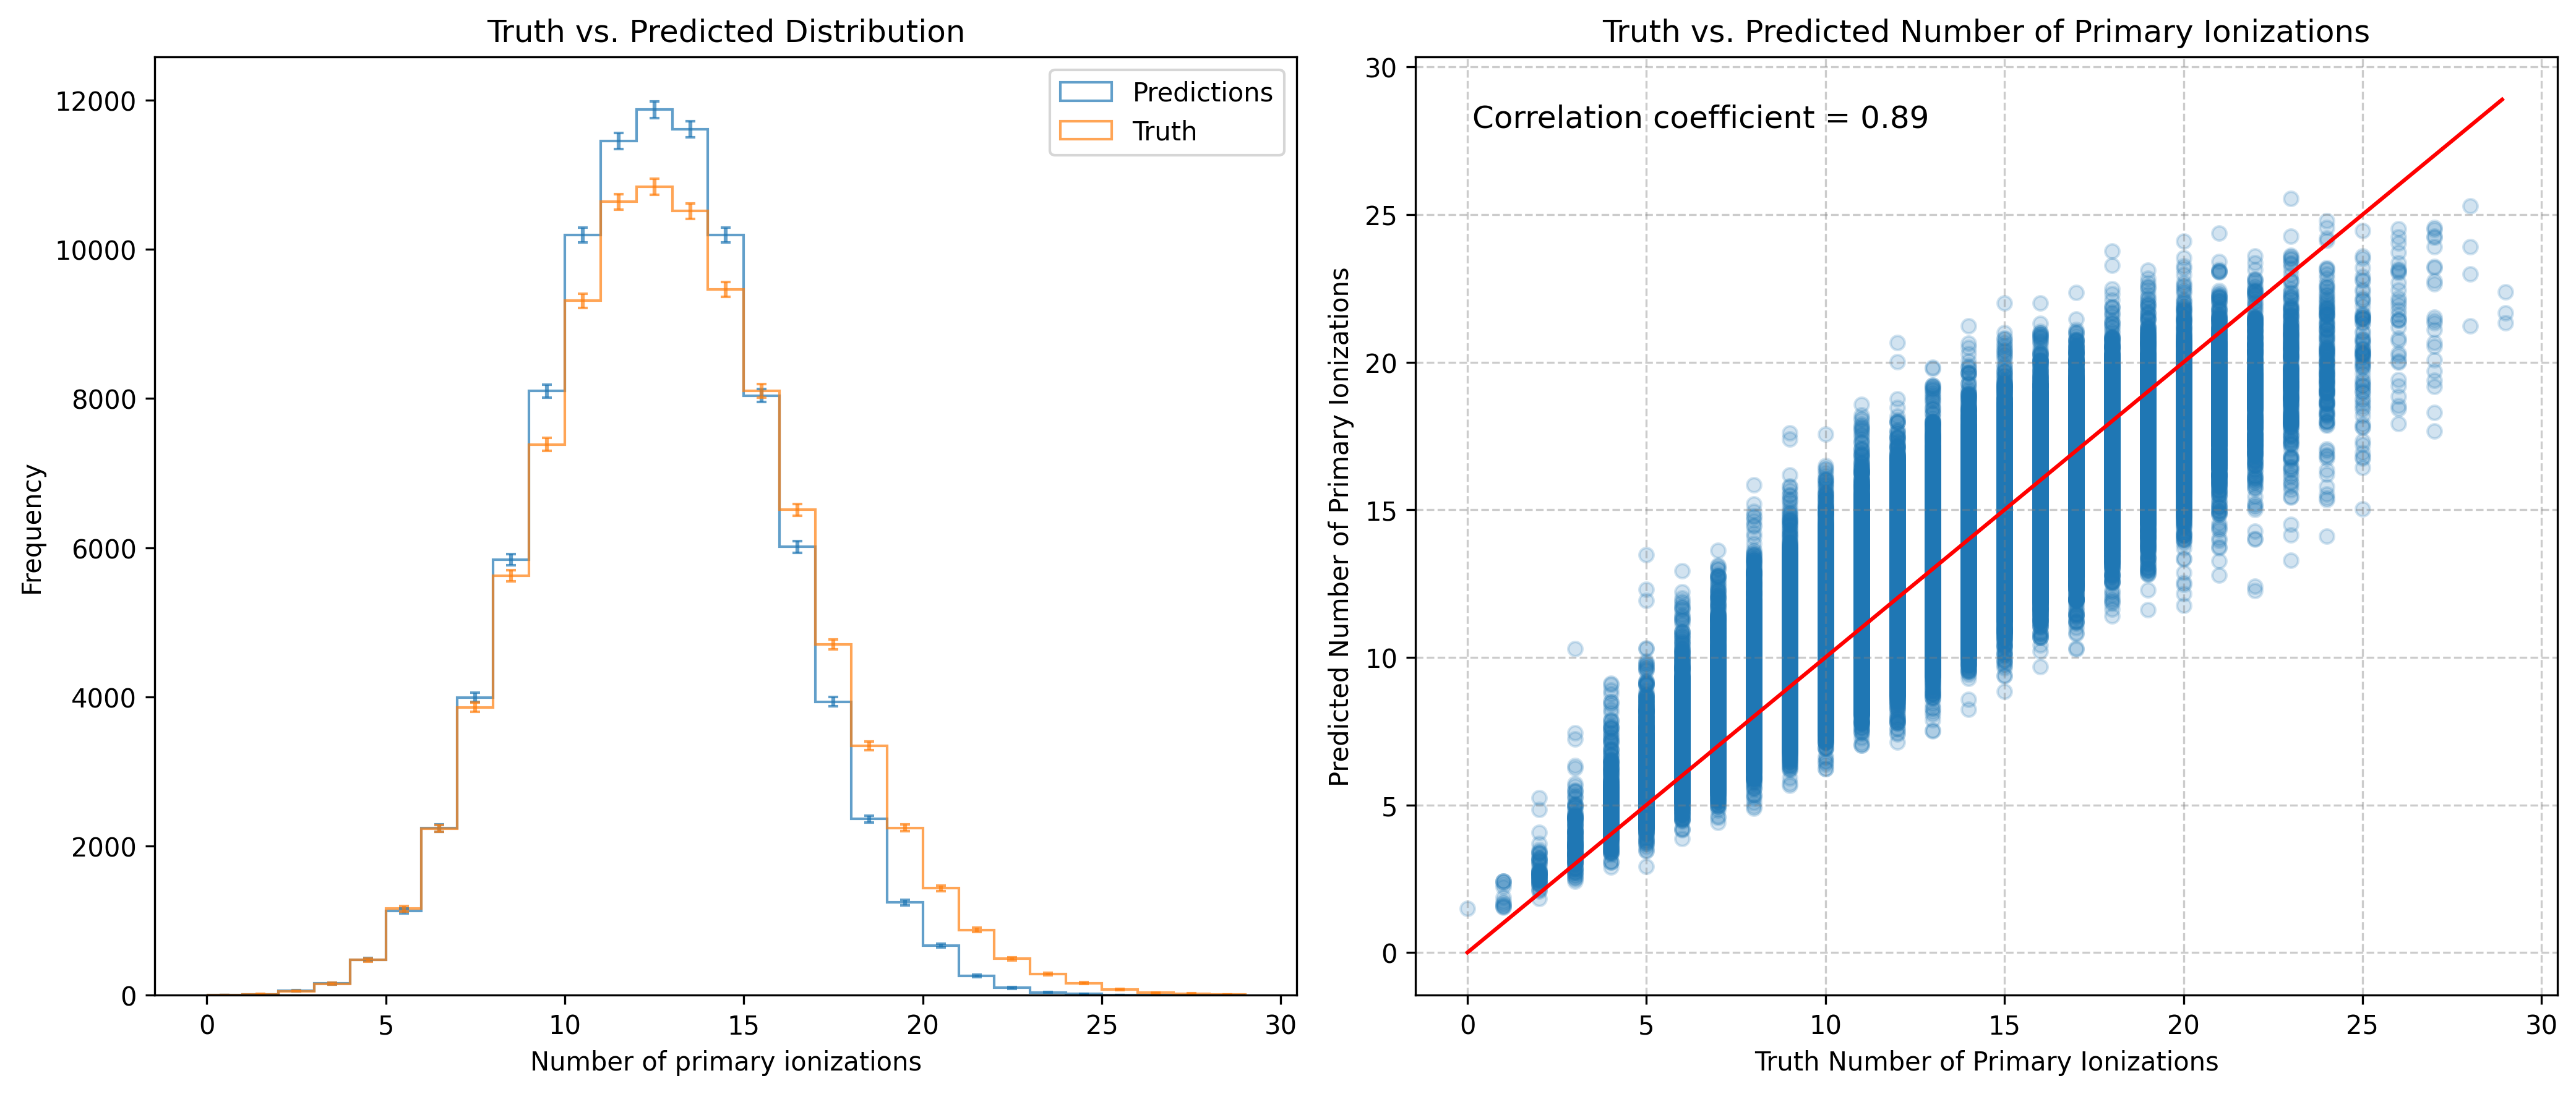

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6), dpi=300)

# Left subplot: Histogram comparison
bins = np.arange(30)

# Plot histograms and get counts for error bars
pred_counts, pred_bins, pred_patches = axes[0].hist(preds, bins=bins, histtype='step', label='Predictions', alpha=0.7)
truth_counts, truth_bins, truth_patches = axes[0].hist(np.sum(testdata['tag_values']==1, axis=-1), bins=bins, histtype='step', label='Truth', alpha=0.7)

# Add error bars
bin_centers = (bins[:-1] + bins[1:]) / 2
axes[0].errorbar(bin_centers, pred_counts, yerr=np.sqrt(pred_counts), 
                 fmt='none', capsize=2, color=pred_patches[0].get_edgecolor())
axes[0].errorbar(bin_centers, truth_counts, yerr=np.sqrt(truth_counts), 
                 fmt='none', capsize=2, color=truth_patches[0].get_edgecolor())

axes[0].legend()
axes[0].set_xlabel("Number of primary ionizations")
axes[0].set_ylabel("Frequency")
axes[0].set_title('Truth vs. Predicted Distribution')

# Right subplot: Correlation scatter plot
actual = np.sum(testdata['tag_values']==1, axis=-1)  # Make sure this matches your truth data
predicted = preds
m = 1
b = 0
correlation_coefficient, p_value = pearsonr(actual[:10000], predicted[:10000])
x = np.arange(actual.min(), actual.max(), step=0.1)

axes[1].scatter(actual, predicted, s=30, alpha=0.2)
axes[1].plot(x, m*x + b, color='red')
axes[1].set_xlabel('Truth Number of Primary Ionizations')
axes[1].set_ylabel('Predicted Number of Primary Ionizations')
axes[1].text(0.05, 0.95, f"Correlation coefficient = {correlation_coefficient:.2f}", 
             fontsize=12, color='black', 
             transform=axes[1].transAxes,
             horizontalalignment='left',    
             verticalalignment='top')
axes[1].grid(True, color='gray', linestyle='--', alpha=0.4)
axes[1].set_title('Truth vs. Predicted Number of Primary Ionizations')

plt.tight_layout()
plt.show()
fig.savefig(results_dir + 'model_performance.png')

In [64]:
pred_counts[10]

10533.0

In [59]:
np.sqrt(pred_counts)

array([  0.        ,   0.        ,   0.        ,   8.42614977,
        17.97220076,  27.29468813,  41.38840417,  58.48931526,
        74.50503339,  88.97190568, 102.63040485, 111.95534824,
       115.78860048, 113.28283189, 105.7355191 ,  92.13576938,
        74.90660852,  57.33236433,  39.61060464,  24.73863375,
        13.41640786,   4.58257569,   1.41421356,   1.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ])

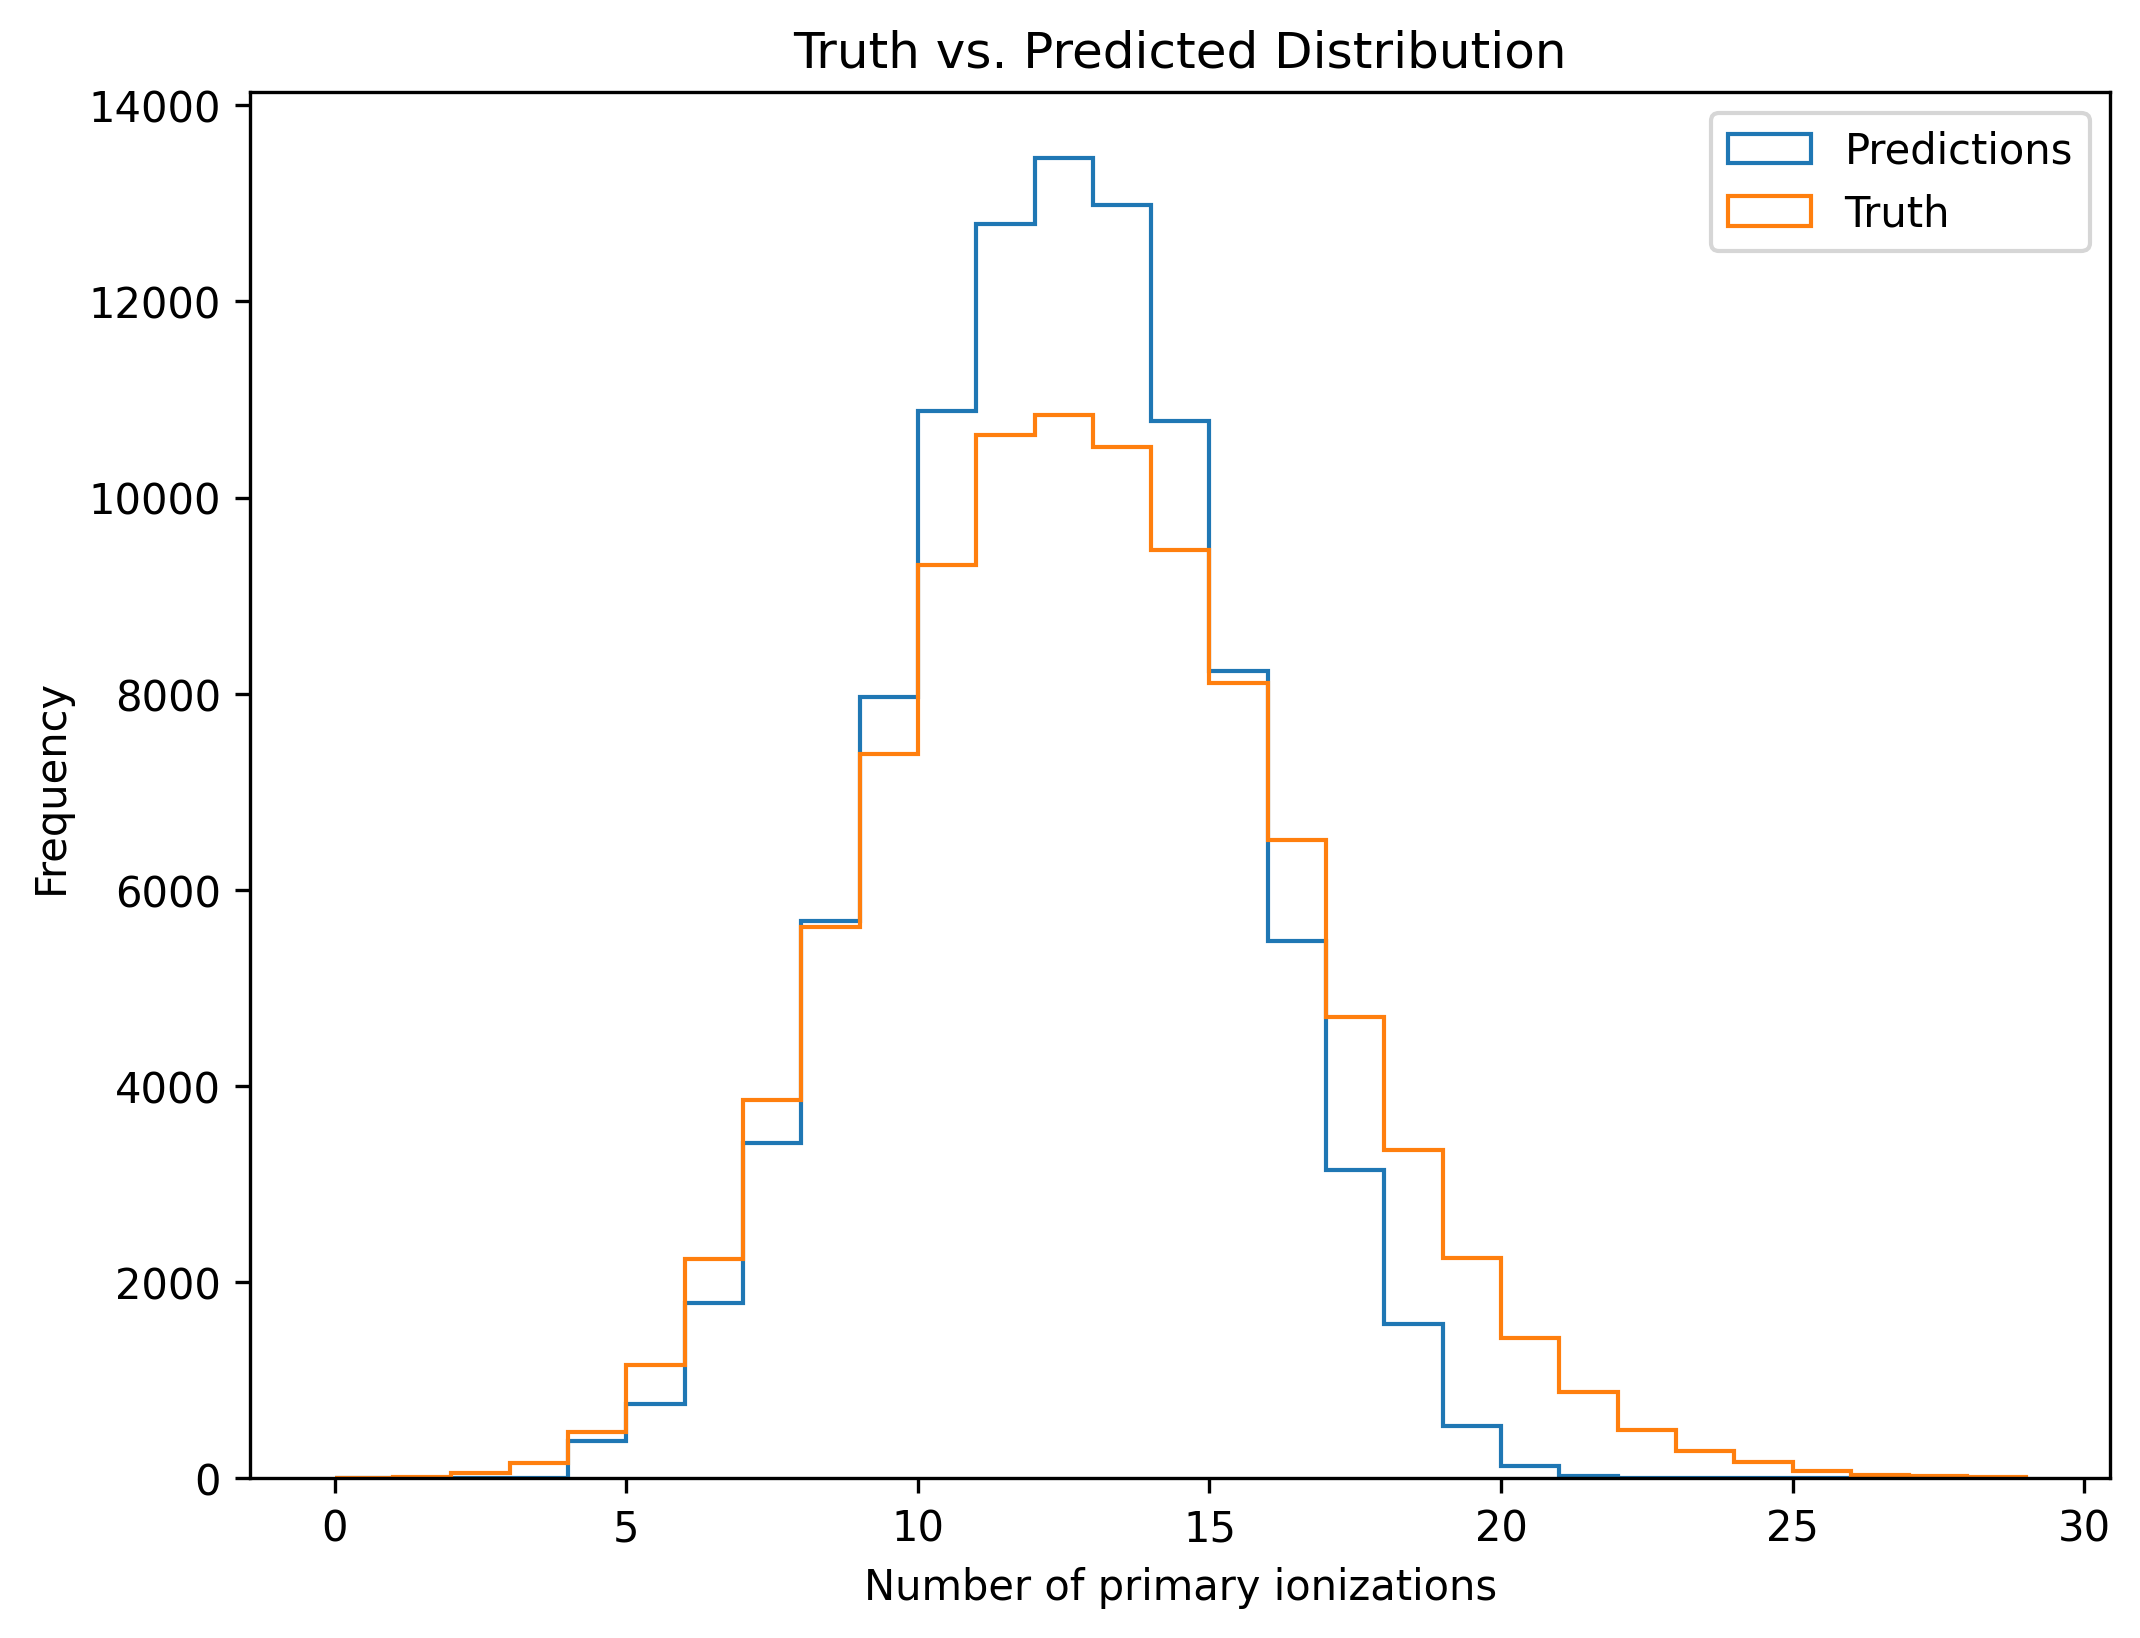

In [ ]:
plt.figure(figsize=(8, 6), dpi=300)
_,bins,_ = plt.hist(preds,bins=np.arange(30),histtype='step',label='Predictions')
plt.hist(np.sum(testdata['tag_values']==1,axis=-1),bins=bins,histtype='step',label='Truth')
plt.legend()
plt.xlabel("Number of primary ionizations")
plt.ylabel("Frequency")
plt.title('Truth vs. Predicted Distribution')
plt.savefig('model_distribution.png')

In [ ]:
percent_error = 100*(preds - actual)/preds

In [ ]:
model.save('models/500_dense_8_32_8.keras')

In [ ]:
bins = []
for i in range(actual.min(), actual.max() + 1, 3):
    bins.append(i)

means = []
stds = []
for bin in bins:
    left_edge = bin
    right_edge = bin + 3

    mask = (actual >= left_edge) & (actual < right_edge)

    curr_percent_error = np.asarray(percent_error[mask])
    means.append(np.mean(curr_percent_error))
    stds.append(np.std(curr_percent_error))

bins = np.asarray(bins) + 2


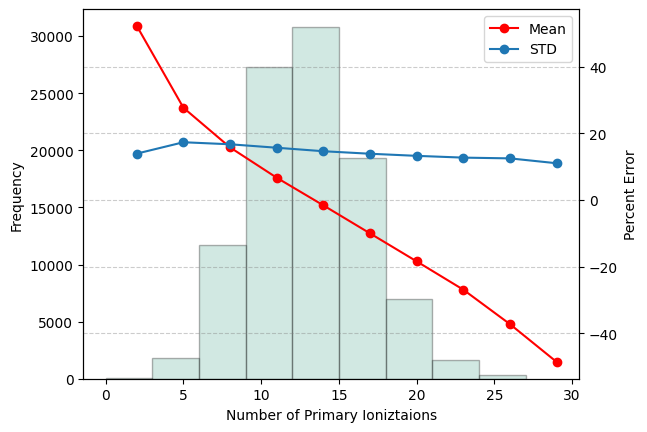

In [ ]:
fig, ax1 = plt.subplots()
ax1.hist(actual, histtype='bar', bins=np.arange(actual.min(), actual.max() + 1, 3), edgecolor="black", fc="#69b3a2", alpha=0.3)
ax1.set_ylabel("Frequency")
ax1.set_xlabel("Number of Primary Ioniztaions")

ax2 = ax1.twinx()
ax2.set_ylabel("Percent Error")
ax2.plot(bins, means, marker='o', label='Mean', color= 'r')
ax2.plot(bins, stds, marker='o', label='STD')
plt.grid(True, color='gray', linestyle='--', alpha=0.4)
plt.legend()

# Quantized Version

### Inspecting values of weights

In [ ]:
model = keras.models.load_model(model_dir + "DNN_8_32_84.keras")

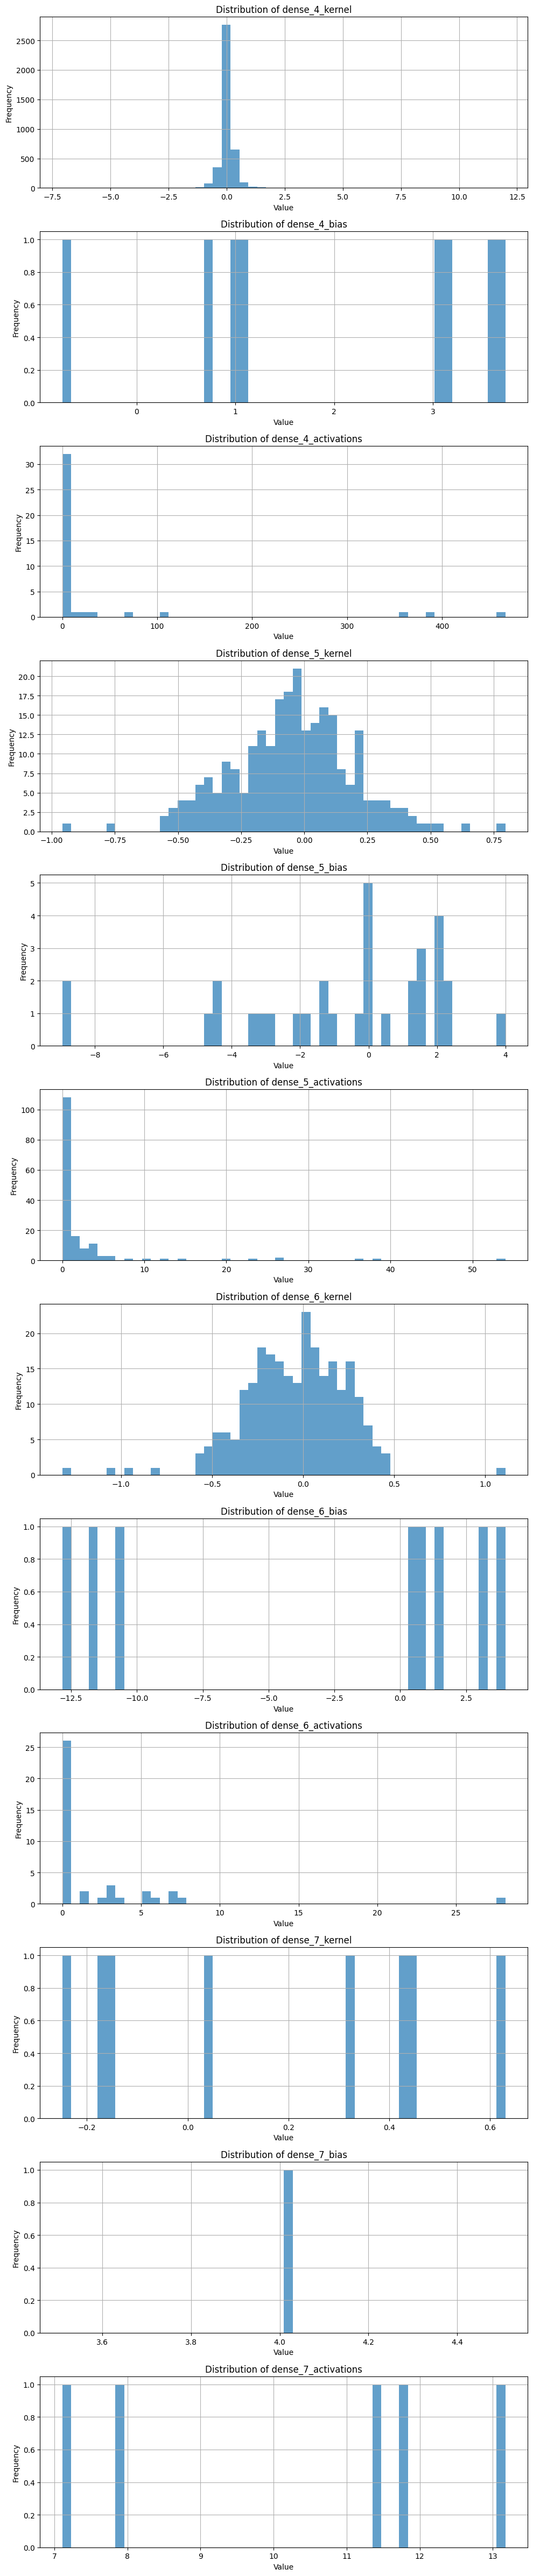

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def plot_distributions(model, X_test, layer_names=None):
    """
    Plots the distributions of weights, biases, and activations for each layer of a Keras model.

    Args:
        model: A trained Keras or QKeras model.
        X_test: A numpy array of test data to generate activation distributions.
        layer_names: An optional list of specific layer names to plot. If None, plots all layers with weights.
    """
    # 1. Get the distributions for all layers
    all_distributions = {}

    for layer in model.layers:
        layer_name = layer.name

        # Check if we should filter by layer name
        if layer_names and layer_name not in layer_names:
            continue

        # Get the weights and biases
        if hasattr(layer, 'weights') and layer.weights:
            for weight_tensor in layer.weights:
                weight_name = weight_tensor.name.split('/')[-1].replace(':0', '')
                data = weight_tensor.numpy().flatten()
                all_distributions[f'{layer_name}_{weight_name}'] = data

        # Get the activations
        if hasattr(layer, 'activation') or isinstance(layer, (tf.keras.layers.Activation)):
            try:
                # Create a temporary model to get the output of the activation layer
                intermediate_model = tf.keras.Model(inputs=model.input, outputs=layer.output)
                activations = intermediate_model.predict(X_test, verbose=0).flatten()
                all_distributions[f'{layer_name}_activations'] = activations
            except Exception as e:
                print(f"Could not get activations for layer {layer_name}. Error: {e}")
                
    # 2. Plot the distributions
    num_plots = len(all_distributions)
    if num_plots == 0:
        print("No distributions to plot.")
        return

    fig, axes = plt.subplots(num_plots, 1, figsize=(10, 4 * num_plots))
    if num_plots == 1:
        axes = [axes]

    for i, (name, data) in enumerate(all_distributions.items()):
        ax = axes[i]
        ax.hist(data, bins=50, alpha=0.7)
        ax.set_title(f'Distribution of {name}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.grid(True)

    plt.tight_layout()
    plt.show()

# # Now, call the function to plot the distributions
plot_distributions(model, testdata['wf_i'][:5])



In [ ]:
# if yes quantization

from qkeras.utils import _add_supported_quantized_objects

co = {}
_add_supported_quantized_objects(co)
model = keras.models.load_model('models/0.6_pruned_q_6_2_regression_dndxgru_focal.h5', custom_objects=co)

['dense_4', 'dense_5', 'dense_6', 'dense_7']
[[-4.507705, -5.8367133, -4.3635573, 3.0193293, 4.560972, -0.6571148, 3.7689214, -5.910068, 9.844278, 10.877856, 10.26496, -4.460533, -7.079511, 3.313497, -5.8623366, 11.999188, -4.7965193, -5.6887584, -5.1331944, 3.4715114, 4.0757537, -1.1495254, 2.9841495, -6.5712037, -0.47530842, 0.14157222, 0.1693684, 1.5910265, 0.2900728, 0.43232766, 0.24602143, 0.26509234, -0.37189683, -0.4247893, -0.023094378, 0.82836425, 0.35544452, -0.7649635, -0.86912596, -0.46806648, -1.0591154, -0.35506293, -0.7587052, 0.013313873, -0.62604135, 0.5406371, -0.5919304, -0.12968728, -0.14393143, -0.17916074, 0.5201771, 0.8001803, 0.6084657, -0.33320996, 0.33773768, -0.68566227, 0.28708032, 0.3017647, -0.6878117, -0.05544506, 0.09798955, 0.6379945, 0.8615828, -0.25021142, -0.26179224, -0.039192967, -0.31248194, 0.9277738, 0.36864027, 0.2650087, 0.5525655, 0.04322039, 0.1964657, 0.0040778136, -0.9064859, 1.3692429, -0.9248523, 0.6548528, -0.75123715, 0.2081725, -0.210

/tmp/ipykernel_1216098/2792548403.py:76: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(layer_weights, vert = False, patch_artist=True, labels = layer_names)


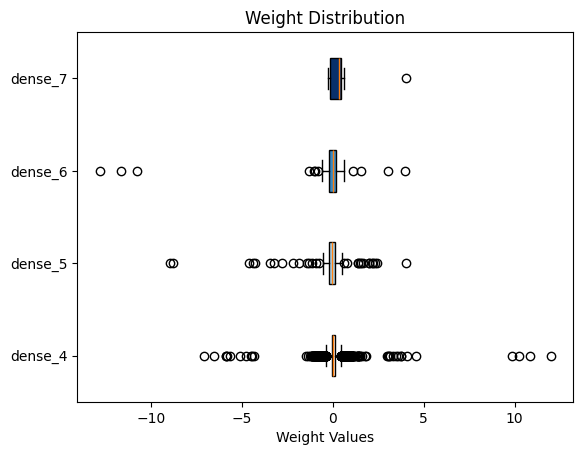

In [27]:
box_plot_weights(model)
    

% of zeros = 0.5925925925925926


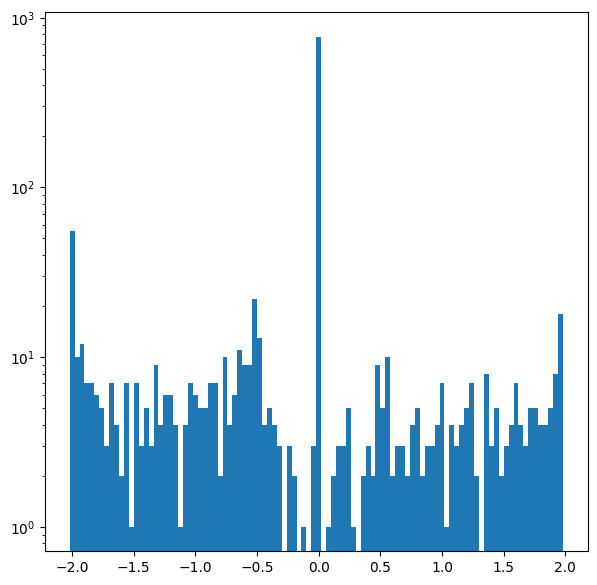

In [ ]:
w = []
flatten_list(model.layers[2].get_weights(), w)
w = np.asarray(w)
h, b = np.histogram(w, bins=100)
plt.figure(figsize=(7, 7))
plt.bar(b[:-1], h, width=b[1] - b[0])
plt.semilogy()
print('% of zeros = {}'.format(np.sum(w == 0) / np.size(w)))

### Quantization aware training

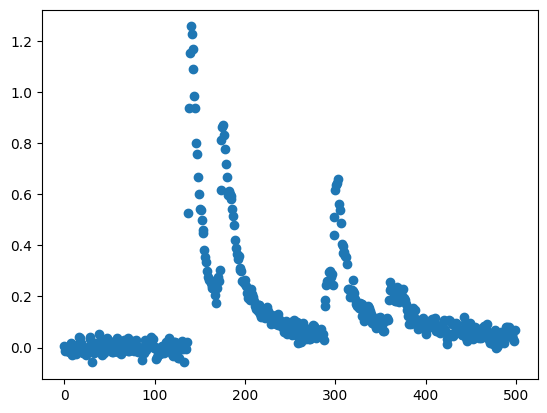

In [62]:
# seeing by how much we can quantize the input layer

from qkeras import * 

input_quantizer = quantized_bits(16, 5, symmetric=0)
input_quantizer(testdata['wf_i'][0]).numpy()

plt.scatter(np.arange(500), input_quantizer(testdata['wf_i'][0]).numpy())

In [40]:
import keras
from keras.layers import Dense, Input, AveragePooling1D, Reshape, GlobalAveragePooling1D, MaxPooling1D, Flatten
from qkeras import *

kernel_bias_quantizer = quantized_bits(6, 2, symmetric=1)
relu_quantizer = quantized_relu(6, 4)
linear_quantizer = quantized_bits(6, 5)
input_quantizer = quantized_bits(16, 5)

tf.random.set_seed(13)
np.random.seed(13)

def create_model():
    inputs = Input(shape=(int(num_timepoints/compress_factor),))
    x = inputs

    x = QActivation(input_quantizer)(x)

    x = QDense(8, kernel_quantizer=kernel_bias_quantizer,
        bias_quantizer=kernel_bias_quantizer)(x)
    
    x = QActivation(relu_quantizer)(x)

    x = QDense(32, kernel_quantizer=kernel_bias_quantizer,
        bias_quantizer=kernel_bias_quantizer)(x)
    
    x = QActivation(relu_quantizer)(x)

    x = QDense(8, kernel_quantizer=kernel_bias_quantizer,
        bias_quantizer=kernel_bias_quantizer)(x)
    
    x = QActivation(relu_quantizer)(x)

    x = QDense(1,kernel_quantizer=kernel_bias_quantizer,
        bias_quantizer=kernel_bias_quantizer)(x)
    
    x = QActivation(linear_quantizer)(x)
    
    outputs = x

    return keras.Model(inputs=inputs, outputs=outputs, name="DNN")


In [41]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.optimizers import Adam

from qkeras import *

loss_fn = tf.keras.losses.MeanSquaredError()
batchSize = 64
nEpochs = 75
learningRate = 6e-4

earlystop = EarlyStopping(
        monitor="val_loss", 
        patience=10,
        restore_best_weights=True,
        min_delta=0.0, 
    )

reducelr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_delta=0.,
    min_lr=1.e-7,
)

model = create_model()

print(model.summary())
# Define Optimizer and compile
opt = Adam(learning_rate=learningRate)
model.compile(loss=loss_fn, optimizer=opt,
    metrics=tf.keras.metrics.MeanAbsoluteError(name='mae'))

history = model.fit(train_ds, validation_data=val_ds,
                    batch_size=batchSize, epochs=nEpochs, callbacks=(earlystop,reducelr))

model.save(model_dir + '6_5_bit_quantization_DNN_8_32_8.h5')

Model: "DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 500)]             0         
                                                                 
 q_activation_25 (QActivati  (None, 500)               0         
 on)                                                             
                                                                 
 q_dense_20 (QDense)         (None, 8)                 4008      
                                                                 
 q_activation_26 (QActivati  (None, 8)                 0         
 on)                                                             
                                                                 
 q_dense_21 (QDense)         (None, 32)                288       
                                                                 
 q_activation_27 (QActivati  (None, 32)                0       

In [61]:
model.save(model_dir + '8_4_bit_quantization_DNN_8_32_8.h5')

# Pruning

### Normal

In [44]:
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects

co = {}
_add_supported_quantized_objects(co)
model = load_model(model_dir + '6_5_bit_quantization_DNN_8_32_8.h5', custom_objects=co)

In [47]:
model.summary()

Model: "DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 q_activation (QActivation)  (None, 500)               0         
                                                                 
 q_dense (QDense)            (None, 8)                 4008      
                                                                 
 q_activation_1 (QActivatio  (None, 8)                 0         
 n)                                                              
                                                                 
 q_dense_1 (QDense)          (None, 32)                288       
                                                                 
 q_activation_2 (QActivatio  (None, 32)                0         
 n)                                                            

In [45]:
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.optimizers import Adam

import tempfile

epochs = 25
learningRate = 6e-4
batchSize = 64
loss_fn = tf.keras.losses.MeanSquaredError()
ntest = 100000
sparsity = 0.6

model_for_pruning = model

pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(sparsity, begin_step=0, frequency=100)}
model_for_pruning = prune.prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
opt = Adam(learning_rate=learningRate)
model_for_pruning.compile(optimizer=opt,
            loss=loss_fn,
            metrics=tf.keras.metrics.MeanAbsoluteError(name='mae'))

model_for_pruning.summary()

logdir = tempfile.mkdtemp()

reducelr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_delta=0.,
    min_lr=1.e-7,
)

callbacks = [
tfmot.sparsity.keras.UpdatePruningStep(),
tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

history = model_for_pruning.fit(train_ds, validation_data=val_ds,
                    batch_size=batchSize, epochs=epochs, callbacks=(callbacks, reducelr))

model_for_pruning = strip_pruning(model_for_pruning)

model_for_pruning.save(model_dir +'80_pruned_8_bit_quantization_DNN_8_32_8.h5')


Model: "DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 500)]             0         
                                                                 
 prune_low_magnitude_q_acti  (None, 500)               1         
 vation_25 (PruneLowMagnitu                                      
 de)                                                             
                                                                 
 prune_low_magnitude_q_dens  (None, 8)                 8010      
 e_20 (PruneLowMagnitude)                                        
                                                                 
 prune_low_magnitude_q_acti  (None, 8)                 1         
 vation_26 (PruneLowMagnitu                                      
 de)                                                             
                                                               

6250/6250 [==============================] - 29s 4ms/step - loss: 6.4437 - mae: 1.9564 - val_loss: 5.8010 - val_mae: 1.8627 - lr: 6.0000e-04
Epoch 2/25
6250/6250 [==============================] - 27s 4ms/step - loss: 5.8321 - mae: 1.8694 - val_loss: 5.7817 - val_mae: 1.8584 - lr: 6.0000e-04
Epoch 3/25
6250/6250 [==============================] - 26s 4ms/step - loss: 5.8305 - mae: 1.8694 - val_loss: 5.7794 - val_mae: 1.8633 - lr: 6.0000e-04
Epoch 4/25
6250/6250 [==============================] - 26s 4ms/step - loss: 5.8185 - mae: 1.8677 - val_loss: 5.7373 - val_mae: 1.8509 - lr: 6.0000e-04
Epoch 5/25
6250/6250 [==============================] - 27s 4ms/step - loss: 5.8002 - mae: 1.8643 - val_loss: 5.7530 - val_mae: 1.8590 - lr: 6.0000e-04
Epoch 6/25
6250/6250 [==============================] - 27s 4ms/step - loss: 5.8193 - mae: 1.8679 - val_loss: 5.9847 - val_mae: 1.9033 - lr: 6.0000e-04
Epoch 7/25
6250/6250 [==============================] - 27s 4ms/step - loss: 5.7884 - mae: 1.8627 -

In [52]:
model_for_pruning.save(model_dir +'60_pruned_6_5_bit_quantization_DNN_8_32_8.h5')

/u1/dyilmaz/conda/envs/hls4ml_alt_CEPC/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/u1/dyilmaz/conda/envs/hls4ml_alt_CEPC/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [ ]:
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.optimizers import Adam

import tempfile

epochs = 7
learningRate = 1e-3
batchSize = 64
loss_fn = tf.keras.losses.MeanSquaredError()

sparsity_values = [0.2, 0.4, 0.6, 0.8, 0.99]

def pruning_scan(sparsity_values, model):

    model_paths = []
    for sparsity in sparsity_values:
        print("============================== SPARSITY: " + str(sparsity) + "==============================")
        model_for_pruning = model

        pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(sparsity, begin_step=0, frequency=100)}
        model_for_pruning = prune.prune_low_magnitude(model, **pruning_params)

        # `prune_low_magnitude` requires a recompile.
        opt = Adam(learning_rate=learningRate)
        model_for_pruning.compile(optimizer=opt,
                    loss=loss_fn,
                    metrics=tf.keras.metrics.MeanAbsoluteError(name='mae'))

        # model_for_pruning.summary()

        logdir = tempfile.mkdtemp()

        callbacks = [
        tfmot.sparsity.keras.UpdatePruningStep(),
        tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
        ]

        history = model_for_pruning.fit(train_ds, validation_data=val_ds,
                            batch_size=batchSize, epochs=epochs, callbacks=callbacks)

        model_for_pruning = strip_pruning(model_for_pruning)

        model_for_pruning.save('models/cf_30_pruned_tiny_dense/' + str(sparsity) + '_sparsity.keras')

        model_paths.append('models/cf_30_pruned_tiny_dense/' + str(sparsity) + '_sparsity.keras')

    return model_paths

model_paths = pruning_scan(sparsity_values, model)

============================== SPARSITY: 0.2==============================
Epoch 1/7
      1/Unknown - 14s 14s/step - loss: 6.2946 - mae: 1.9273WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0008s vs `on_train_batch_end` time: 0.0041s). Check your callbacks.


2025-08-04 15:35:57.632712: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1 of 512
2025-08-04 15:35:57.638306: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


6250/6250 [==============================] - 45s 5ms/step - loss: 6.1694 - mae: 1.8901 - val_loss: 5.9064 - val_mae: 1.8849
Epoch 2/7
6250/6250 [==============================] - 36s 5ms/step - loss: 5.6901 - mae: 1.8515 - val_loss: 5.4687 - val_mae: 1.8236
Epoch 3/7
6250/6250 [==============================] - 38s 5ms/step - loss: 5.8052 - mae: 1.8482 - val_loss: 5.4884 - val_mae: 1.8286
Epoch 4/7
6250/6250 [==============================] - 37s 5ms/step - loss: 5.5095 - mae: 1.8308 - val_loss: 5.3991 - val_mae: 1.8135
Epoch 5/7
6250/6250 [==============================] - 38s 5ms/step - loss: 5.5603 - mae: 1.8316 - val_loss: 5.4524 - val_mae: 1.8158
Epoch 6/7
6250/6250 [==============================] - 39s 5ms/step - loss: 5.4344 - mae: 1.8230 - val_loss: 5.4349 - val_mae: 1.8101
Epoch 7/7
6250/6250 [==============================] - 38s 5ms/step - loss: 5.4212 - mae: 1.8208 - val_loss: 5.3978 - val_mae: 1.8048


INFO:tensorflow:Assets written to: models/cf_30_pruned_tiny_dense/0.2_sparsity/assets


INFO:tensorflow:Assets written to: models/cf_30_pruned_tiny_dense/0.2_sparsity/assets


============================== SPARSITY: 0.4==============================
Epoch 1/7
      1/Unknown - 8s 8s/step - loss: 4.1189 - mae: 1.5428WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0008s vs `on_train_batch_end` time: 0.0018s). Check your callbacks.


6250/6250 [==============================] - 39s 5ms/step - loss: 6.5901 - mae: 1.8985 - val_loss: 5.6647 - val_mae: 1.8318
Epoch 2/7
6250/6250 [==============================] - 39s 5ms/step - loss: 5.5209 - mae: 1.8293 - val_loss: 5.3216 - val_mae: 1.8062
Epoch 3/7
6250/6250 [==============================] - 39s 5ms/step - loss: 5.4868 - mae: 1.8249 - val_loss: 5.5311 - val_mae: 1.8366
Epoch 4/7
6250/6250 [==============================] - 38s 5ms/step - loss: 5.4135 - mae: 1.8167 - val_loss: 5.9164 - val_mae: 1.8715
Epoch 5/7
6250/6250 [==============================] - 39s 5ms/step - loss: 5.4186 - mae: 1.8172 - val_loss: 5.3510 - val_mae: 1.8100
Epoch 6/7
6250/6250 [==============================] - 39s 5ms/step - loss: 5.3679 - mae: 1.8132 - val_loss: 5.3224 - val_mae: 1.8076
Epoch 7/7
6250/6250 [==============================] - 38s 5ms/step - loss: 5.3928 - mae: 1.8138 - val_loss: 5.5249 - val_mae: 1.8293


INFO:tensorflow:Assets written to: models/cf_30_pruned_tiny_dense/0.4_sparsity/assets


INFO:tensorflow:Assets written to: models/cf_30_pruned_tiny_dense/0.4_sparsity/assets


============================== SPARSITY: 0.6==============================
Epoch 1/7
      1/Unknown - 7s 7s/step - loss: 8.3978 - mae: 2.0158WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0008s vs `on_train_batch_end` time: 0.0016s). Check your callbacks.


6250/6250 [==============================] - 41s 5ms/step - loss: 5.4859 - mae: 1.8342 - val_loss: 5.8760 - val_mae: 1.8335
Epoch 2/7
6250/6250 [==============================] - 40s 5ms/step - loss: 5.3994 - mae: 1.8190 - val_loss: 5.3385 - val_mae: 1.8113
Epoch 3/7
6250/6250 [==============================] - 39s 5ms/step - loss: 5.3360 - mae: 1.8122 - val_loss: 5.2834 - val_mae: 1.8033
Epoch 4/7
6250/6250 [==============================] - 39s 5ms/step - loss: 5.3219 - mae: 1.8093 - val_loss: 5.9341 - val_mae: 1.8184
Epoch 5/7
6250/6250 [==============================] - 37s 5ms/step - loss: 5.3169 - mae: 1.8074 - val_loss: 5.3315 - val_mae: 1.8090
Epoch 6/7
6250/6250 [==============================] - 37s 5ms/step - loss: 5.3061 - mae: 1.8056 - val_loss: 5.2743 - val_mae: 1.8011
Epoch 7/7
6250/6250 [==============================] - 39s 5ms/step - loss: 5.3515 - mae: 1.8082 - val_loss: 5.5002 - val_mae: 1.8292


INFO:tensorflow:Assets written to: models/cf_30_pruned_tiny_dense/0.6_sparsity/assets


INFO:tensorflow:Assets written to: models/cf_30_pruned_tiny_dense/0.6_sparsity/assets


============================== SPARSITY: 0.8==============================
Epoch 1/7
      1/Unknown - 8s 8s/step - loss: 8.2250 - mae: 1.9563WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0008s vs `on_train_batch_end` time: 0.0031s). Check your callbacks.


6250/6250 [==============================] - 41s 5ms/step - loss: 5.7661 - mae: 1.8771 - val_loss: 5.6075 - val_mae: 1.8523
Epoch 2/7
6250/6250 [==============================] - 39s 5ms/step - loss: 5.5507 - mae: 1.8474 - val_loss: 5.5044 - val_mae: 1.8388
Epoch 3/7
6250/6250 [==============================] - 39s 5ms/step - loss: 5.5315 - mae: 1.8440 - val_loss: 5.4846 - val_mae: 1.8361
Epoch 4/7
6250/6250 [==============================] - 42s 5ms/step - loss: 5.5141 - mae: 1.8405 - val_loss: 5.4815 - val_mae: 1.8357
Epoch 5/7
6250/6250 [==============================] - 40s 5ms/step - loss: 5.4971 - mae: 1.8383 - val_loss: 5.4656 - val_mae: 1.8337
Epoch 6/7
6250/6250 [==============================] - 40s 5ms/step - loss: 5.4839 - mae: 1.8357 - val_loss: 5.4602 - val_mae: 1.8310
Epoch 7/7
6250/6250 [==============================] - 39s 5ms/step - loss: 5.4593 - mae: 1.8315 - val_loss: 5.4116 - val_mae: 1.8255


INFO:tensorflow:Assets written to: models/cf_30_pruned_tiny_dense/0.8_sparsity/assets


INFO:tensorflow:Assets written to: models/cf_30_pruned_tiny_dense/0.8_sparsity/assets


============================== SPARSITY: 0.99==============================
Epoch 1/7
      1/Unknown - 8s 8s/step - loss: 4.9471 - mae: 1.6877WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0006s vs `on_train_batch_end` time: 0.0016s). Check your callbacks.


6250/6250 [==============================] - 40s 5ms/step - loss: 29.8575 - mae: 4.4121 - val_loss: 15.5156 - val_mae: 3.0912
Epoch 2/7
6250/6250 [==============================] - 39s 5ms/step - loss: 13.6753 - mae: 2.9445 - val_loss: 13.3732 - val_mae: 2.9296
Epoch 3/7
6250/6250 [==============================] - 39s 5ms/step - loss: 13.3646 - mae: 2.9286 - val_loss: 13.3732 - val_mae: 2.9295
Epoch 4/7
6250/6250 [==============================] - 39s 5ms/step - loss: 13.3646 - mae: 2.9286 - val_loss: 13.3731 - val_mae: 2.9296
Epoch 5/7
6250/6250 [==============================] - 40s 5ms/step - loss: 13.3645 - mae: 2.9286 - val_loss: 13.3731 - val_mae: 2.9296
Epoch 6/7
6250/6250 [==============================] - 38s 5ms/step - loss: 13.3646 - mae: 2.9286 - val_loss: 13.3732 - val_mae: 2.9296
Epoch 7/7
6250/6250 [==============================] - 39s 5ms/step - loss: 13.3646 - mae: 2.9286 - val_loss: 13.3732 - val_mae: 2.9296


INFO:tensorflow:Assets written to: models/cf_30_pruned_tiny_dense/0.99_sparsity/assets


INFO:tensorflow:Assets written to: models/cf_30_pruned_tiny_dense/0.99_sparsity/assets


In [55]:
model_paths = os.listdir('models/cf_30_pruned_tiny_dense/')

for i in range(len(model_paths)):
    model_paths[i] = 'models/cf_30_pruned_tiny_dense/' + model_paths[i]


In [63]:
preds = model.predict(testdata['wf_i'])

def compute_error(model_path, ntest, preds):
    model = keras.models.load_model(model_path)

    preds = model.predict(testdata['wf_i'])
    actual = np.sum(testdata['tag_values'] == 1, axis = 1)

    preds = np.asarray(preds.astype(np.float16))[:ntest].reshape(ntest)
    actual = np.asarray(actual.astype(np.float16))[:ntest].reshape(ntest)

    mask = actual != 0
    actual = actual[mask]
    preds = preds[mask]

    error = ((preds - actual)/actual) * 100

    mean = np.mean(error)
    std = np.std(error.astype(np.float32))

    return mean, std

3125/3125 [==============================] - 1s 307us/step


In [53]:
og_model_path = 'models/500_dense_8_32_8.keras'

In [64]:
model_paths

['models/cf_30_pruned_tiny_dense/0.8_sparsity',
 'models/cf_30_pruned_tiny_dense/0.99_sparsity',
 'models/cf_30_pruned_tiny_dense/0.2_sparsity',
 'models/cf_30_pruned_tiny_dense/0.6_sparsity',
 'models/cf_30_pruned_tiny_dense/0.4_sparsity']

In [65]:
model_means = []
model_stds = []

for model_path in model_paths:
    mean, std = compute_error(model_path, ntest, preds)
    model_means.append(mean)
    model_stds.append(std)

# include 0 sparsity model
sparsity_values.append(0)
mean, std = compute_error(og_model_path, ntest, preds)
model_means.append(mean)
model_stds.append(std)

3125/3125 [==============================] - 1s 314us/step


3125/3125 [==============================] - 2s 532us/step


3125/3125 [==============================] - 1s 295us/step


3125/3125 [==============================] - 1s 288us/step


3125/3125 [==============================] - 1s 301us/step


In [66]:
sparsity_values = []

for model_path in model_paths:
    temp = model_path.split("/")[2].split("_")
    print(temp[0])
    sparsity_values.append(float(temp[0]))

sparsity_values.append(0)

0.8
0.99
0.2
0.6
0.4


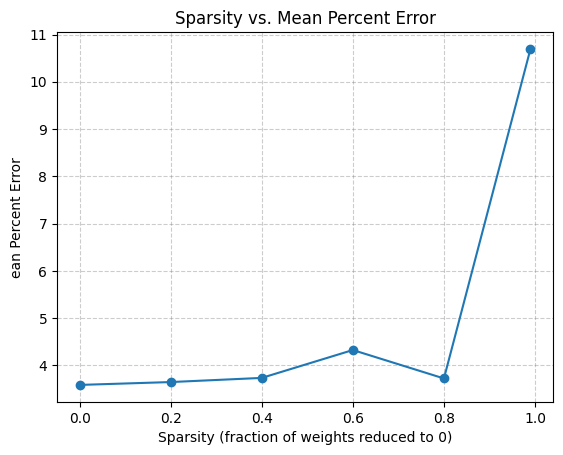

In [69]:
import matplotlib.pyplot as plt
def plot_sparsity_against_error(sparsity_values, model_means, model_stds):
    plt.errorbar(np.sort(sparsity_values), np.asarray(model_means)[np.argsort(sparsity_values)], fmt='o-')
    plt.xlabel("Sparsity (fraction of weights reduced to 0)")
    plt.ylabel("ean Percent Error")
    plt.grid(True, color='gray', linestyle='--', alpha=0.4)
    plt.title("Sparsity vs. Mean Percent Error")


plot_sparsity_against_error(sparsity_values, model_means, model_stds)

In [78]:
model = keras.models.load_model('models/500_pruned_8_32_8/0.99_sparsity')
model.save('models/500_pruned_8_32_8/0.99_sparsity.keras')

### Pruning Scan

In [23]:
from qkeras import * 

from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects

co = {}
_add_supported_quantized_objects(co)
model = load_model(model_dir + 'hls4ml/10_5_500_dense_8_32_8_lr=3e-4.h5', custom_objects=co)

import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.optimizers import Adam

import tempfile

In [24]:
epochs = 7
learningRate = 6e-4
batchSize = 64
loss_fn = tf.keras.losses.MeanSquaredError()

sparsity_values = [0.2, 0.4, 0.6, 0.8, 0.99]

============================== SPARSITY: 0.2==============================
Epoch 1/7
      1/Unknown - 5s 5s/step - loss: 6.4966 - mae: 2.0918WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0008s vs `on_train_batch_end` time: 0.0028s). Check your callbacks.


6250/6250 [==============================] - 27s 3ms/step - loss: 5.5799 - mae: 1.8548 - val_loss: 5.4485 - val_mae: 1.8292
Epoch 2/7
6250/6250 [==============================] - 25s 3ms/step - loss: 5.5143 - mae: 1.8435 - val_loss: 5.3045 - val_mae: 1.8085
Epoch 3/7
6250/6250 [==============================] - 25s 3ms/step - loss: 5.5020 - mae: 1.8410 - val_loss: 5.3524 - val_mae: 1.8170
Epoch 4/7
6250/6250 [==============================] - 25s 3ms/step - loss: 5.4633 - mae: 1.8342 - val_loss: 5.4634 - val_mae: 1.8417
Epoch 5/7
6250/6250 [==============================] - 25s 3ms/step - loss: 5.4502 - mae: 1.8316 - val_loss: 5.4199 - val_mae: 1.8175
Epoch 6/7
6250/6250 [==============================] - 25s 3ms/step - loss: 5.4699 - mae: 1.8363 - val_loss: 6.6572 - val_mae: 2.0001
Epoch 7/7
3125/3125 [==============================] - 1s 430us/step
============================== SPARSITY: 0.4==============================
Epoch 1/7
      1/Unknown - 5s 5s/step - loss: 5.9832 - mae: 1

6250/6250 [==============================] - 26s 3ms/step - loss: 5.7353 - mae: 1.8796 - val_loss: 5.4526 - val_mae: 1.8275
Epoch 2/7
6250/6250 [==============================] - 25s 3ms/step - loss: 5.8176 - mae: 1.8935 - val_loss: 5.3494 - val_mae: 1.8148
Epoch 3/7
6250/6250 [==============================] - 25s 3ms/step - loss: 5.8431 - mae: 1.8966 - val_loss: 5.4784 - val_mae: 1.8380
Epoch 4/7
6250/6250 [==============================] - 25s 3ms/step - loss: 5.8283 - mae: 1.8952 - val_loss: 5.4507 - val_mae: 1.8249
Epoch 5/7
6250/6250 [==============================] - 24s 3ms/step - loss: 5.8461 - mae: 1.8980 - val_loss: 5.3743 - val_mae: 1.8168
Epoch 6/7
6250/6250 [==============================] - 25s 3ms/step - loss: 5.8715 - mae: 1.9028 - val_loss: 5.4094 - val_mae: 1.8326
Epoch 7/7
3125/3125 [==============================] - 2s 475us/step
============================== SPARSITY: 0.6==============================
Epoch 1/7
      1/Unknown - 4s 4s/step - loss: 5.2576 - mae: 1

6250/6250 [==============================] - 26s 3ms/step - loss: 5.9152 - mae: 1.8977 - val_loss: 5.7694 - val_mae: 1.8721
Epoch 2/7
6250/6250 [==============================] - 24s 3ms/step - loss: 5.7544 - mae: 1.8788 - val_loss: 5.5169 - val_mae: 1.8422
Epoch 3/7
6250/6250 [==============================] - 25s 3ms/step - loss: 5.8851 - mae: 1.9006 - val_loss: 5.4989 - val_mae: 1.8378
Epoch 4/7
6250/6250 [==============================] - 25s 3ms/step - loss: 5.8942 - mae: 1.9031 - val_loss: 5.4715 - val_mae: 1.8332
Epoch 5/7
6250/6250 [==============================] - 24s 3ms/step - loss: 5.8741 - mae: 1.9001 - val_loss: 5.4378 - val_mae: 1.8289
Epoch 6/7
6250/6250 [==============================] - 24s 3ms/step - loss: 5.9275 - mae: 1.9103 - val_loss: 5.4408 - val_mae: 1.8326
Epoch 7/7
3125/3125 [==============================] - 2s 453us/step
============================== SPARSITY: 0.8==============================
Epoch 1/7
      1/Unknown - 5s 5s/step - loss: 5.9219 - mae: 1

6250/6250 [==============================] - 26s 3ms/step - loss: 9.0714 - mae: 2.3061 - val_loss: 6.7539 - val_mae: 2.0304
Epoch 2/7
6250/6250 [==============================] - 25s 3ms/step - loss: 6.6474 - mae: 2.0177 - val_loss: 6.4605 - val_mae: 1.9876
Epoch 3/7
6250/6250 [==============================] - 25s 3ms/step - loss: 6.9147 - mae: 2.0595 - val_loss: 8.3061 - val_mae: 2.2493
Epoch 4/7
6250/6250 [==============================] - 25s 3ms/step - loss: 6.9539 - mae: 2.0666 - val_loss: 6.6521 - val_mae: 2.0279
Epoch 5/7
6250/6250 [==============================] - 25s 3ms/step - loss: 6.5916 - mae: 2.0122 - val_loss: 6.6120 - val_mae: 2.0062
Epoch 6/7
6250/6250 [==============================] - 25s 3ms/step - loss: 6.8560 - mae: 2.0523 - val_loss: 6.1075 - val_mae: 1.9393
Epoch 7/7
3125/3125 [==============================] - 2s 462us/step
============================== SPARSITY: 0.99==============================
Epoch 1/7
      1/Unknown - 5s 5s/step - loss: 6.1640 - mae: 

6250/6250 [==============================] - 26s 3ms/step - loss: 44.1447 - mae: 5.2593 - val_loss: 13.3884 - val_mae: 2.9258
Epoch 2/7
6250/6250 [==============================] - 25s 3ms/step - loss: 13.3724 - mae: 2.9288 - val_loss: 13.3884 - val_mae: 2.9258
Epoch 3/7
6250/6250 [==============================] - 25s 3ms/step - loss: 13.3730 - mae: 2.9287 - val_loss: 13.3884 - val_mae: 2.9258
Epoch 4/7
6250/6250 [==============================] - 25s 3ms/step - loss: 13.3713 - mae: 2.9286 - val_loss: 13.3884 - val_mae: 2.9258
Epoch 5/7
6250/6250 [==============================] - 25s 3ms/step - loss: 13.3712 - mae: 2.9286 - val_loss: 13.3884 - val_mae: 2.9258
Epoch 6/7
6250/6250 [==============================] - 25s 3ms/step - loss: 13.3731 - mae: 2.9288 - val_loss: 13.3771 - val_mae: 2.9320
Epoch 7/7
3125/3125 [==============================] - 1s 399us/step


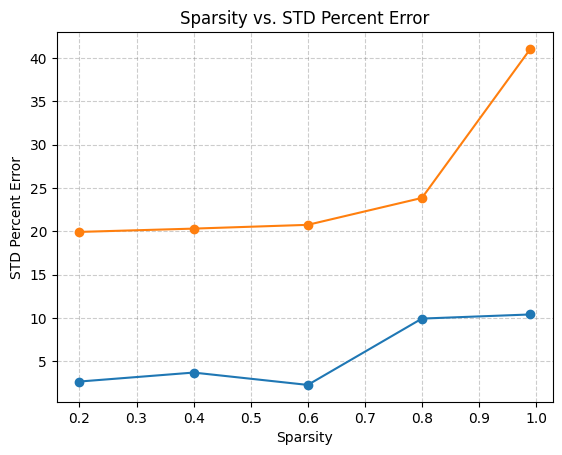

In [ ]:
def pruning_scan(sparsity_values, model):

    model_paths = []
    mean_error = []
    std_error = []
    for sparsity in sparsity_values:
        print("============================== SPARSITY: " + str(sparsity) + "==============================")

        co = {}
        _add_supported_quantized_objects(co)
        model = load_model(model_dir + 'hls4ml/10_5_500_dense_8_32_8_lr=3e-4.h5', custom_objects=co)


        model_for_pruning = model

        pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(sparsity, begin_step=0, frequency=100)}
        model_for_pruning = prune.prune_low_magnitude(model, **pruning_params)

        # `prune_low_magnitude` requires a recompile.
        opt = Adam(learning_rate=learningRate)
        model_for_pruning.compile(optimizer=opt,
                    loss=loss_fn,
                    metrics=tf.keras.metrics.MeanAbsoluteError(name='mae'))

        # model_for_pruning.summary()

        logdir = tempfile.mkdtemp()

        callbacks = [
        tfmot.sparsity.keras.UpdatePruningStep(),
        tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
        ]

        history = model_for_pruning.fit(train_ds, validation_data=val_ds,
                            batch_size=batchSize, epochs=epochs, callbacks=callbacks)

        model_for_pruning = strip_pruning(model_for_pruning)

        

        preds = model_for_pruning.predict(testdata['wf_i'])
        actual = np.sum(testdata['tag_values'] == 1, axis = 1)

        preds = np.asarray(preds.astype(np.float16))[:1000].reshape(1000)
        actual = np.asarray(actual.astype(np.float16))[:1000].reshape(1000)

        mask = actual != 0
        actual = actual[mask]
        preds = preds[mask]

        error = ((preds - actual)/actual) * 100

        mean = np.mean(error)
        std = np.std(error.astype(np.float32))

        mean_error.append(mean)
        std_error.append(std)

    return mean_error, std_error



mean_error, std_error = pruning_scan(sparsity_values, model)


import matplotlib.pyplot as plt
def plot_sparsity_against_mean_error(sparsity_values, model_means):
    plt.errorbar(np.sort(sparsity_values), np.asarray(model_means)[np.argsort(sparsity_values)], fmt='o-')
    plt.xlabel("Sparsity")
    plt.ylabel("Mean Percent Error")
    plt.grid(True, color='gray', linestyle='--', alpha=0.4)
    plt.title("Sparsity vs. Mean Percent Error")
    plt.savefig(results_dir + 'sparsity_vs_mean_error.png')

def plot_sparsity_against_std_error(sparsity_values, std_means):
    plt.errorbar(np.sort(sparsity_values), np.asarray(std_means)[np.argsort(sparsity_values)], fmt='o-')
    plt.xlabel("Sparsity")
    plt.ylabel("STD Percent Error")
    plt.grid(True, color='gray', linestyle='--', alpha=0.4)
    plt.title("Sparsity vs. STD Percent Error")
    plt.savefig(results_dir + 'sparsity_vs_std_error.png')

plot_sparsity_against_mean_error(sparsity_values, mean_error)

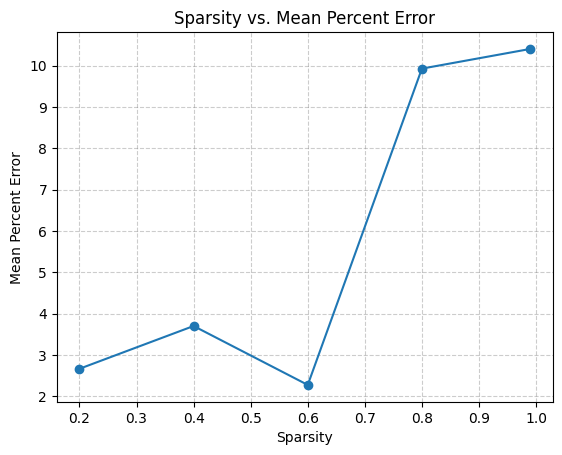

In [31]:
plot_sparsity_against_mean_error(sparsity_values, mean_error)